### Importing Required Packages

In [62]:
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.geocoding import geocode
from IPython.display import display, Image
from arcgis.raster import ImageryLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geometry import Polygon, Envelope
from arcgis.raster.functions import clip
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.geometry import mapping, Polygon
import fiona
from osgeo import gdal, gdalconst, gdal_array
from osgeo import ogr
import os
import pkg_resources
import whitebox
import imageio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings

!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.geocoding import geocode
from IPython.display import display, Image
from arcgis.raster import ImageryLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geometry import Polygon, Envelope
from arcgis.raster.functions import clip

from osgeo import gdal, gdalconst, gdal_array
import pylab as plt
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
%pylab inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Populating the interactive namespace from numpy and matplotlib


In [2]:
gis = GIS(url='https://nkwjones.maps.arcgis.com',username='nj935_',password='')
print("Logged on as {}".format(gis.properties.user["username"]))

Logged on as nj935_


### 1. Get data: borders, elevation, population

Lets start by fetching the popoulation and elevation grid layers from ESRI's catalog. Also, We'll have to clip these global datasets for each country, so we'll also download the world boundaries layers from the catalog

In [3]:
ESRI_pop = gis.content.get('625e9da1afed40b78aaf412f519b22d3')
pop_lyr = ESRI_pop.layers[0]

In [4]:
ESRI_elevation = gis.content.get('58a541efc59545e6b7137f961d7de883')
elev_lyr = ESRI_elevation.layers[0]

In [5]:
world_boundaries = gis.content.get("2b93b06dc0dc4e809d3c8db5cb96ba69")
boundary_lyr = world_boundaries.layers[0]

### 2. Create a table of SIDS

Create a list of countries under SIDS and then create a spatial dataframe from the boundary layer.

In [6]:

SIDS = [
'Antigua and Barbuda','Cook Islands','Cape Verde','Federated States of Micronesia','Comoros',
    'Bahamas','Guinea-Bissau','Barbados','Maldives','Belize','Mauritius','Kiribati','São Tomé and Príncipe',
    'Cuba','Marshall Islands','Seychelles','Dominica','Nauru','Dominican Republic','Grenada',
    'Niue','Guyana','Palau','Papua New Guinea','Samoa','Solomon Islands',
    'Timor-Leste','Saint Kitts and Nevis','Tonga','Saint Lucia','Tuvalu',
    'Saint Vincent and the Grenadines','Vanuatu','Suriname','Trinidad and Tobago']

In [7]:
SIDS_table = pd.DataFrame.spatial.from_layer(boundary_lyr)
SIDS_table.drop(columns=['AFF_ISO','FID','ISO','COUNTRYAFF'],inplace=True)
SIDS_table = SIDS_table[SIDS_table['Country'].isin(SIDS)]
SIDS_table.set_index("Country",inplace=True)
SIDS_table['Country'] = SIDS_table.index

In [8]:
SIDS_table.head()

,SHAPE,Country
Country,,
Guyana,"{""rings"": [[[-6475746.20510377, 760125.6448030...",Guyana
Suriname,"{""rings"": [[[-6136816.88138343, 649239.6407875...",Suriname
Trinidad and Tobago,"{""rings"": [[[-6799332.82943668, 1212172.394016...",Trinidad and Tobago
Cook Islands,"{""rings"": [[[-17782952.6897151, -2422510.55083...",Cook Islands
Niue,"{""rings"": [[[-18912501.4387227, -2172080.18490...",Niue


After getting rid of the unwanted columns from the dataset, we now have just the shape and name for each of the countries.

### 3. Output population and elevation rasters

The next step would be to clip the rasters to each countries boundaries and save the result in form of a rsater file. We've created a function here **output_raster** that does the job for us.

In [9]:
def check_status(status):
    
    '''
    This function checks the status of your command line arguments for creating a new directory and prints the response
    '''
    
    if status == 0:
        print('New directory of rasters created')
    elif status == 256:
        print('Directory already exists')
    else:
        print('Error code: {}'.format(status))

In [10]:
# Variables for the raster export function
# set the export folder here
status = os.system("rasters_oct_16")

check_status(status)

folder = 'rasters_oct_16'

## Extracting spatial reference so that clipped rasters have the same reference

sr = pop_lyr.properties.spatialReference

names_dict = {pop_lyr:"pop",elev_lyr:"elev"}

Error code: 32512


In [11]:
from arcgis.raster.functions import clip

def output_raster(country,layer):
    
    '''
    Function to output rasters for elevation or population, clipped to national borders
    '''
    
    filename = names_dict[layer]+'_'+str(country)

    AOI = geocode(country,category = "Country",out_sr=sr)[0]['extent']
    AOI['spatialReference'] = sr
    layer.extent = AOI

    clipped = clip(layer,SIDS_table.at[country,'SHAPE'])
    clipped.export_image(f='image', bbox = AOI, export_format='tiff',
                    save_folder = folder, save_file=filename)

In [12]:
## Populate population and elevation rasters for all the countries defined under SIDS

for i in SIDS_table.Country[:]:
    output_raster(i, pop_lyr)
    output_raster(i, elev_lyr)

### 4. Visualize the results

To see how the elevation data looks like in a raster form, we'll create a function to plot them.

In [76]:
def show_elev(country,max_elev):
    '''
    This function provides the raster visualization of each country. It also takes a parameter for
    max elevation which would plot only the subset of data less than the max elevation.
    
    Input:
    Country: str; country name
    max_elev: int; extent of elevation to show on the image
    
    Returns:
    An image with pixels having value greater than max elevation
    '''
    folder = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_oct_16'
    
    elev_data = gdal.Open(folder + '/elev_' + country)
    elev = elev_data.ReadAsArray()
    
    pop_data = gdal.Open(folder + '/pop_' + country, gdal.GA_ReadOnly)
    pop = pop_data.ReadAsArray()
    
    mask = ((elev>0) & (elev<max_elev))
    plt.figure(figsize=(12,8))
    plt.imshow(mask)
    plt.title("{}: Land up to {} m".format(country,max_elev))

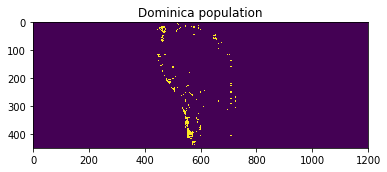

In [14]:
country = "Dominica"
img_data = gdal.Open(folder+'/pop_'+country, gdal.GA_ReadOnly)
img = img_data.ReadAsArray()
plt.imshow((img>1) & (img<100000))
plt.title("{} population".format(country));

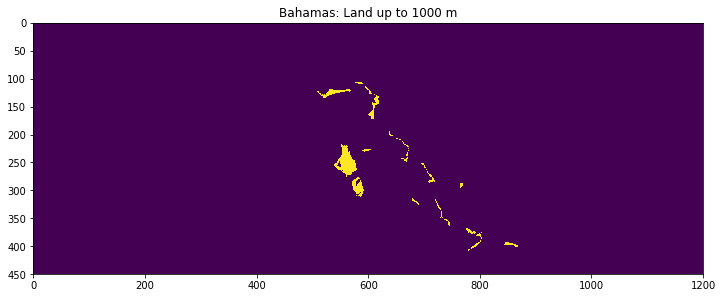

In [94]:
show_elev('Bahamas', 1000)

### Get max elevation for each country

In [99]:
def get_elevation(country):
    #folder = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_oct_16/'
    
    con = gdal.Open('/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_oct_16/elev_'+country)
    data = con.ReadAsArray()
    elev = np.max(data)
    
    return elev

In [104]:
elevation_list = []
work = []
for i in SIDS:
    try:
        elevation_list.append(get_elevation(i))
        work.append(i)
    except:
        pass

In [109]:
elev_data = pd.DataFrame()
elev_data['Country'] = work
elev_data['Elevation'] = elevation_list

In [145]:
elev_data.sort_values('Elevation',ascending=False).round(2)

,Country,Elevation
21,Papua New Guinea,4076.54
16,Dominican Republic,2998.89
24,Timor-Leste,2802.90
2,Cape Verde,2622.97
3,Comoros,2332.00
19,Guyana,2233.53
23,Solomon Islands,1991.23
22,Samoa,1821.54
11,Cuba,1671.44
30,Vanuatu,1601.19


### 5. Calculate population at different elevations

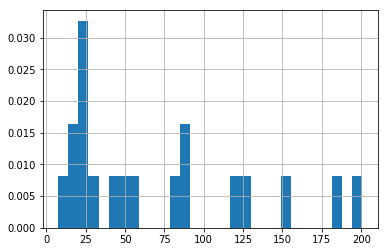

In [119]:
def elev_hist(country,bins=30):
    elev = gdal.Open(folder + "/elev_" + country, gdal.GA_ReadOnly)
    elev = elev.ReadAsArray().flatten()
    elev = elev[(elev>1) & (elev<1000)]
    hist = pd.Series(elev).hist(bins=bins,normed=True)
    return(hist)

elev_hist('Cook Islands')

In [18]:
SIDS_to_plot = ['Antigua and Barbuda',
 'Cook Islands',
 'Cape Verde',
 'Comoros',
 'Bahamas',
 'Barbados',
 'Maldives',
 'Belize',
 'Mauritius',
 'Cuba',
 'Marshall Islands',
 'Seychelles',
 'Dominica',
 'Nauru',
 'Dominican Republic',
 'Grenada',
 'Niue',
 'Guyana',
 'Palau',
 'Samoa',
 'Timor-Leste',
 'Saint Kitts and Nevis',
 'Tonga',
 'Saint Lucia',
 'Tuvalu',
 'Saint Vincent and the Grenadines',
 'Vanuatu',
 'Suriname',
 'Trinidad and Tobago']

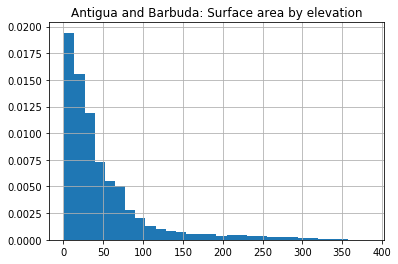

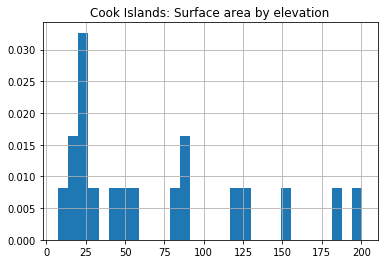

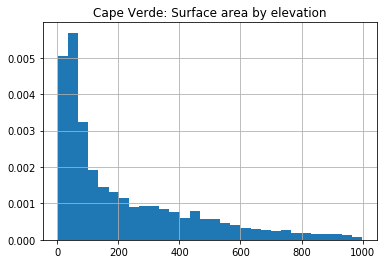

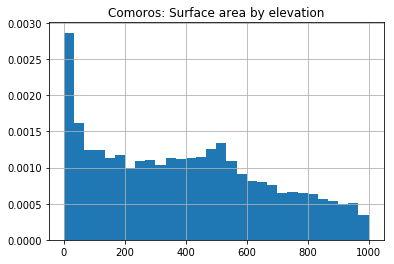

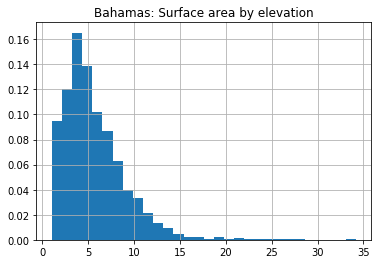

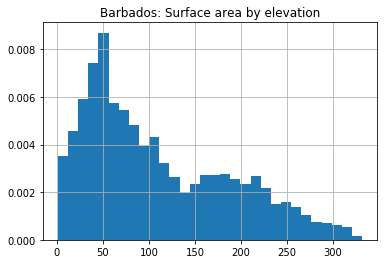

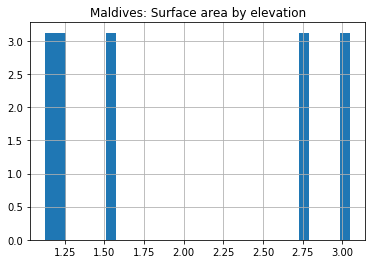

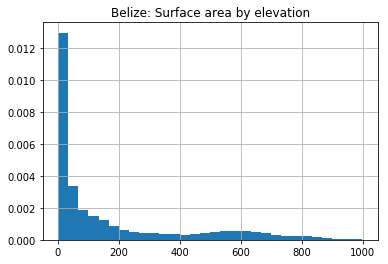

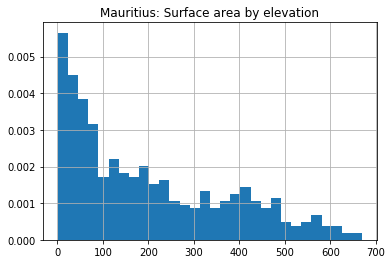

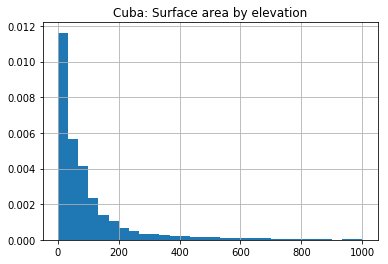

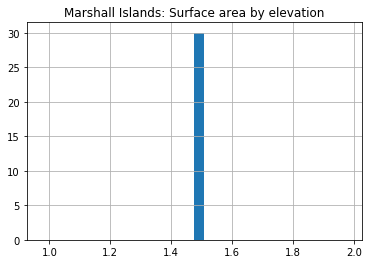

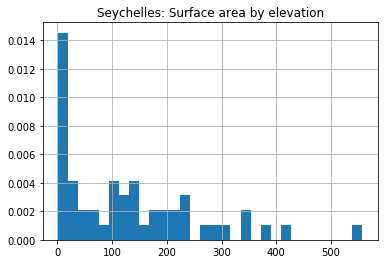

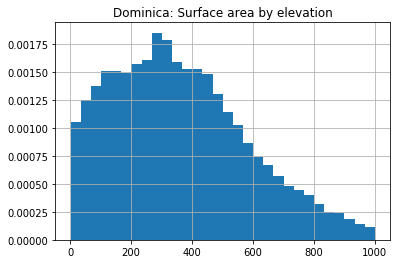

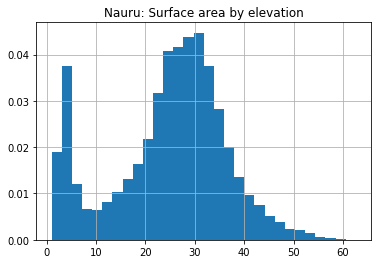

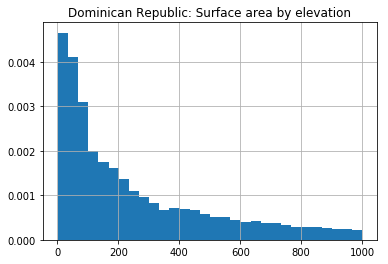

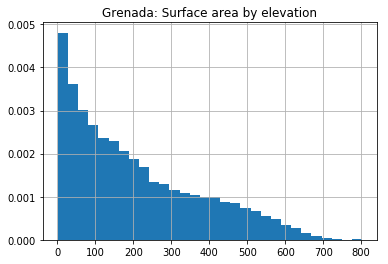

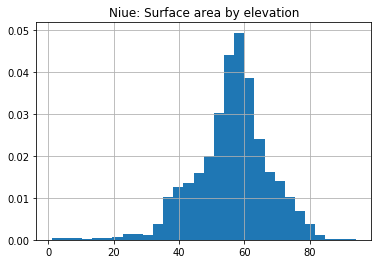

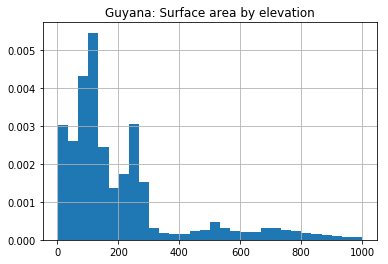

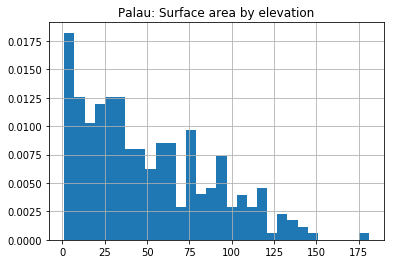

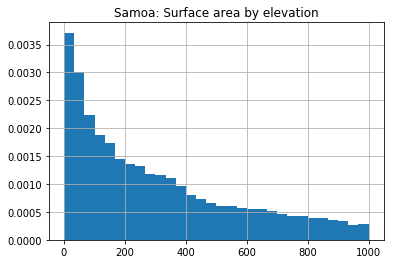

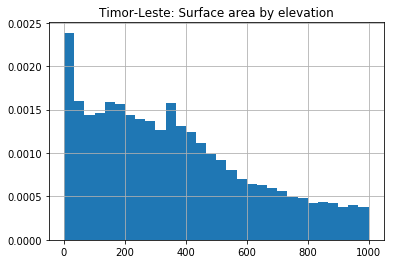

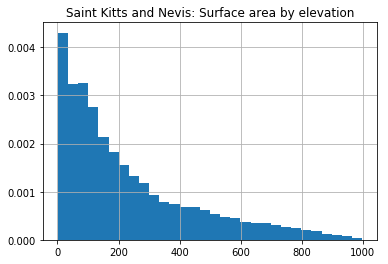

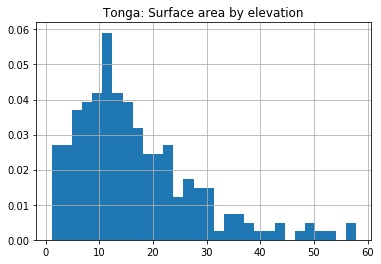

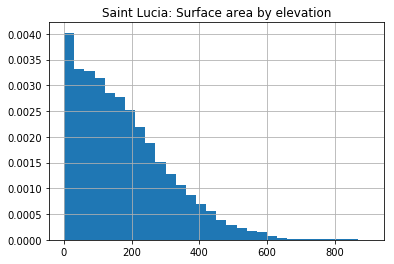

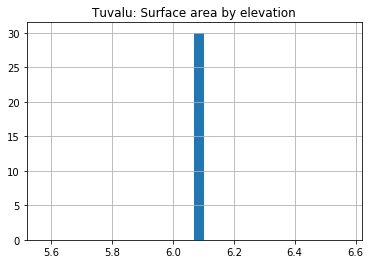

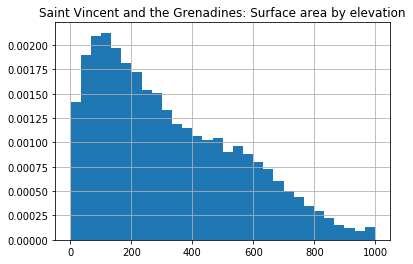

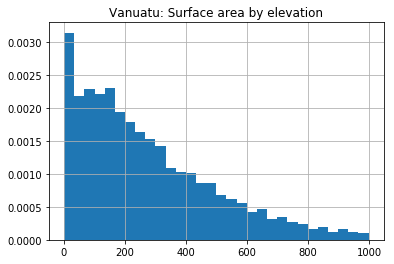

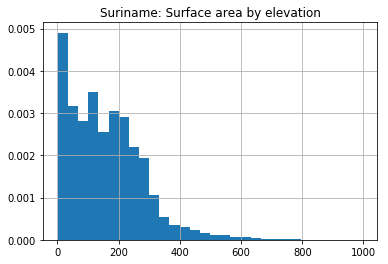

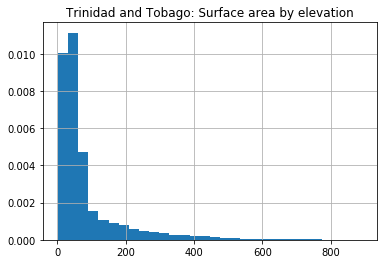

In [18]:
for i in SIDS_to_plot:
    if i:
        elev_hist(i)
        plt.title(i+": Surface area by elevation")
        plt.show()
    else:
        pass

#### Function for calculating population exposed to sea level rise

In [19]:
def count_pop_exposed(country):
    elev_data = gdal.Open(folder + '/elev_' + country, gdal.GA_ReadOnly)
    elev = elev_data.ReadAsArray()
    
    pop_data = gdal.Open(folder + '/pop_' + country, gdal.GA_ReadOnly)
    pop = pop_data.ReadAsArray()
    
    mask_land = (elev>0)
    mask_100m = ((elev>0) & (elev<100))
    mask_50m = ((elev>0) & (elev<50))
    mask_20m = ((elev>0) & (elev<20))
    mask_10m = ((elev>0) & (elev<10))
    mask_5m = ((elev>0) & (elev<5))
    
    output = [np.sum(pop[mask_land]),np.sum(pop[mask_100m]),np.sum(pop[mask_50m]),
          np.sum(pop[mask_20m]),np.sum(pop[mask_10m]),np.sum(pop[mask_5m])]
    
    pop_exposed = pd.DataFrame({"elevation":["all",100,50,20,10,5],"population":output})
    pop_exposed['percent_total'] = (pop_exposed['population'] / pop_exposed.population[0])*100
    
    #pop_exposed.plot.bar(x="elevation",y='percent_total',color='b',
    #                 title='{}: Percent population by meters above sea level'.format(country))
    
    return(pop_exposed.population.tolist(),pop_exposed.percent_total.tolist())

In [20]:
df_pc = pd.DataFrame({"Country":SIDS_table.Country}).set_index('Country').T

In [21]:
df_pc = pd.DataFrame({"Country":SIDS_table.Country}).set_index('Country').T
for i in df_pc.columns:
    try:
        df_pc[i] = count_pop_exposed(i)[1]
    except:
        pass

In [22]:
df_pc.head()

Country,Guyana,Suriname,Trinidad and Tobago,Cook Islands,Niue,Samoa,Tonga,Maldives,Palau,Barbados,...,Seychelles,Timor-Leste,Nauru,Cape Verde,Papua New Guinea,Solomon Islands,Tuvalu,Vanuatu,Guinea-Bissau,Kiribati
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.0
1,79.428587,99.428567,99.999833,100.000000,100.000000,99.999942,100.000000,100.0,100.000000,99.998440,...,71.428569,98.005418,100.000000,96.969655,92.618585,89.267010,100.0,95.203836,100.000000,100.0
2,79.428583,99.428563,99.999497,99.999997,99.975345,99.999852,100.000000,100.0,99.999999,99.996741,...,61.904760,92.877185,99.999984,90.909032,83.831240,74.345544,100.0,84.172660,99.999983,100.0
3,77.714294,97.714275,99.552290,42.857141,99.974523,97.348240,99.999988,100.0,91.176462,95.727025,...,47.619047,77.492562,99.998419,78.354908,68.541261,48.167535,100.0,66.906472,99.021133,100.0
4,72.000012,77.714292,95.980443,28.571428,99.974504,94.696675,87.179458,100.0,76.470582,83.532035,...,38.095228,65.241883,99.997912,68.831101,48.154629,31.151829,100.0,49.880092,92.822093,100.0


### 6. Plot figures

In [23]:
df_pc=df_pc.T
df_pc.columns=["all",'100m','50m','20m','10m','5m']
df_pc.head()

,all,100m,50m,20m,10m,5m
Country,,,,,,
Guyana,100.0,79.428587,79.428583,77.714294,72.000012,65.714295
Suriname,100.0,99.428567,99.428563,97.714275,77.714292,53.142864
Trinidad and Tobago,100.0,99.999833,99.999497,99.552290,95.980443,84.819729
Cook Islands,100.0,100.000000,99.999997,42.857141,28.571428,14.285714
Niue,100.0,100.000000,99.975345,99.974523,99.974504,99.974504


In [24]:
df_pc[['50m','20m','10m','5m']].sort_values('5m',ascending=False).round(2)

,50m,20m,10m,5m
Country,,,,
Marshall Islands,100.00,100.00,100.00,100.00
Maldives,100.00,100.00,100.00,100.00
Nauru,100.00,100.00,100.00,100.00
Niue,99.98,99.97,99.97,99.97
Belize,100.00,100.00,100.00,98.97
Antigua and Barbuda,100.00,100.00,97.45,92.34
Bahamas,100.00,100.00,98.26,91.86
Samoa,100.00,97.35,94.70,86.74
Trinidad and Tobago,100.00,99.55,95.98,84.82


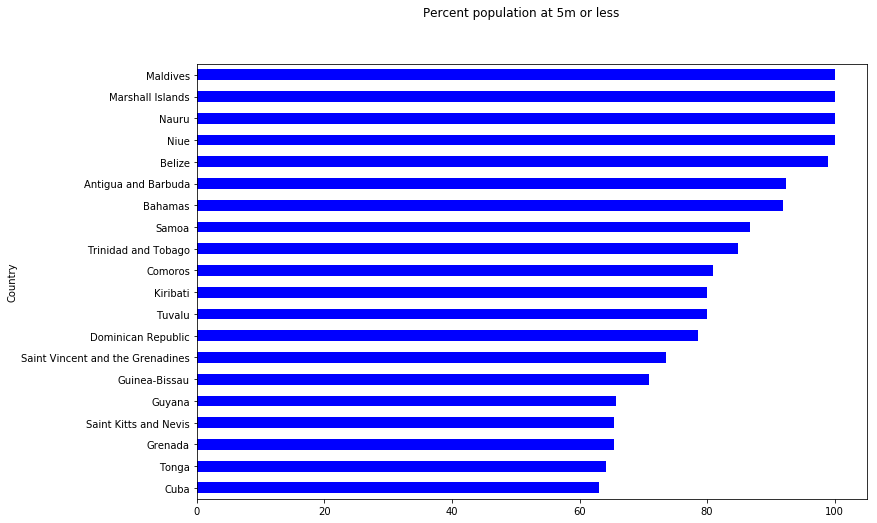

In [25]:
f, ax = plt.subplots(figsize=[12,8])
df_pc['5m'].sort_values(ascending=False)[:20].plot(kind='barh',figsize=[12,8],color='blue', ax=ax)
plt.suptitle("Percent population at 5m or less")
ax.invert_yaxis()

### 7. Grab Global Roads network dataset 

In [26]:
search_result = gis.content.search(query="title: Global Roads", item_type="Feature Layer", max_items = 15, outside_org=True)
search_result

[<Item title:"Global Roads" type:Feature Layer Collection owner:Ashraf.ABUSHADY_UNWFP>,
 <Item title:"Major Global Seaports (PDC)" type:Feature Layer Collection owner:boulw2_bpresponse>,
 <Item title:"Global_Roads" type:Feature Layer Collection owner:jdallinga@wwf.nl_panda>]

<Item title:"Global Roads" type:Feature Layer Collection owner:Ashraf.ABUSHADY_UNWFP>
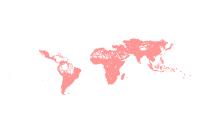

<Item title:"Major Global Seaports (PDC)" type:Feature Layer Collection owner:boulw2_bpresponse>
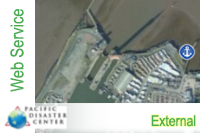

<Item title:"Global_Roads" type:Feature Layer Collection owner:jdallinga@wwf.nl_panda>
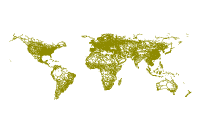

In [27]:
for item in search_result:
    display(item)

In [28]:
roads = gis.content.get('f2d0cdef5bc24c8bb168c50144b1c31b')
road_lyr = roads.layers[0]

In [29]:
SIDS_roads = pd.DataFrame.spatial.from_layer(road_lyr)
SIDS_copy = SIDS_roads.copy()

In [30]:
SIDS_roads.head()

,SHAPE,Shape__Length,adm0_code,adm0_name,bdwthrprac,continent,curntprac,fclass,gdwthrprac,globalid,...,objectid,onme,region,roadid,rtenme,shape_leng,sourceid,srfcond,srfprep,srftpe
0,"{""paths"": [[[71.9235694430001, 34.087517052000...",6.020794e-08,188.0,Pakistan,0.0,Asia,0.0,3.0,0.0,6c5e4e7e-fb82-4311-ae59-2593dc1d717c,...,184020,,Southern Asia,2050856.0,,6.000000e-08,srce201008040002,0.0,0.0,0.0
1,"{""paths"": [[[72.023129758, 34.3385269820001], ...",1.794714e-07,188.0,Pakistan,0.0,Asia,0.0,3.0,0.0,a501469f-eb43-41f7-a236-7bf87b0c7e7e,...,184023,,Southern Asia,2050825.0,,1.800000e-07,srce201008040002,0.0,0.0,0.0
2,"{""paths"": [[[71.968120211, 34.3903213610001], ...",5.980806e-08,188.0,Pakistan,0.0,Asia,0.0,3.0,0.0,daf50678-41df-4b58-8a2a-1ef9a51110e0,...,184025,,Southern Asia,2050848.0,,6.000000e-08,srce201008040002,0.0,0.0,0.0
3,"{""paths"": [[[72.0598255960001, 34.189719504], ...",9.551965e-08,188.0,Pakistan,0.0,Asia,0.0,3.0,0.0,030746e1-1f10-44f3-ab08-46b62db6d46f,...,184015,,Southern Asia,2050886.0,,1.000000e-07,srce201008040002,0.0,0.0,0.0
4,"{""paths"": [[[79.8670256, 6.84159120000004], [7...",2.188264e-05,231.0,Sri Lanka,0.0,Asia,0.0,3.0,0.0,68a9103a-57bd-40f3-9952-3ff75b91f7b3,...,181985,,Southern Asia,2095890.0,,2.188000e-05,srce201012170004,0.0,0.0,0.0


### Subset data for countries and create a shapefile for them

In [32]:
!mkdir roads_shapefile

In [31]:
def poly_to_shapefile(country):
    from shapely.geometry import mapping, Polygon
    import fiona
    from fiona.crs import from_epsg

    # Here's an example Shapely geometry
    subdata = SIDS_roads[SIDS_roads.adm0_name == country]
    #poly =  SIDS_roads.at[country,'SHAPE']

    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'MultiLineString',
        
        'properties': {'id': 'int', 'Shape__Length' : 'float', 'Country' : 'str', 'Region':'str', 'continent':'str',
                      'country_code':'int', 'vals':'int'},
    }

    # Write a new Shapefile
    with fiona.open('roads_shapefile/'+country+'.shp', 'w', 'ESRI Shapefile', schema, from_epsg(4326)) as c:
        ## If there are multiple geometries, put the "for" loop here
        for i in range(len(subdata)):
            poly =  subdata.iloc[i]['SHAPE']
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': i, 'Shape__Length': float(subdata.iloc[i]['shape_leng']), 'Country':country,
                               'Region':subdata.iloc[i]['region'], 'continent': subdata.iloc[i]['continent'], 
                'country_code':int(subdata.iloc[i]['adm0_code']), 'vals':1
                }
            })

In [32]:
for i in SIDS:
    poly_to_shapefile(i)

In [33]:
wbt = whitebox.WhiteboxTools()
wbt.set_working_dir('/nfshome/gb1877/gb1877/WorldBank/ESRI/')
print(wbt.version())
print(wbt.help())

whitebox-tools v0.14.0 by Dr. John B. Lindsay (c) 2017-2019

whitebox-tools Help

The following commands are recognized:
--cd, --wd       Changes the working directory; used in conjunction with --run flag.
-h, --help       Prints help information.
-l, --license    Prints the whitebox-tools license.
--listtools      Lists all available tools. Keywords may also be used, --listtools slope.
-r, --run        Runs a tool; used in conjuction with --wd flag; -r="LidarInfo".
--toolbox        Prints the toolbox associated with a tool; --toolbox=Slope.
--toolhelp       Prints the help associated with a tool; --toolhelp="LidarInfo".
--toolparameters Prints the parameters (in json form) for a specific tool; --toolparameters="LidarInfo".
-v               Verbose mode. Without this flag, tool outputs will not be printed.
--viewcode       Opens the source code of a tool in a web browser; --viewcode="LidarInfo".
--version        Prints the version information.

Example Usage:
>> ./whitebox-tools -r=lid

### Resample and Reproject Elevation Data

In [34]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(raster, country):
    
    raster_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_oct_16/'+raster
    
    #os.chdir('/nfshome/gb1877/gb1877/WorldBank/ESRI/')
    
    dst_crs = 'EPSG:4326'
    crs_src = rasterio.crs.CRS.from_string('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' )
    try:
        with rasterio.open(raster_path, 'r') as src:
            #src.crs = crs_src
            transform, width, height = calculate_default_transform(
              src.crs , dst_crs, src.width, src.height, *src.bounds)

            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            
            if 'elev' in raster_path:
                filename = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
            else:
                filename = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'_reprojected.tif'

            with rasterio.open(filename, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):

                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
            
    except:
        with rasterio.open(raster_path, 'r+') as src:
            src.crs = crs_src
            transform, width, height = calculate_default_transform(
              src.crs , dst_crs, src.width, src.height, *src.bounds)

            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            
            
            if 'elev' in raster_path:
                filename = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
            else:
                filename = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'_reprojected.tif'

            with rasterio.open(filename, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):

                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        dst_nodata=0,
                        resampling=Resampling.nearest)

In [35]:
from rasterio.errors import RasterioIOError
for i in SIDS:
    try:
        reproject_raster('elev_'+i, i)
    except RasterioIOError:
        pass

### Rasterize Shapefile

In [36]:
def rasterize_shapefile_wbt(country):
    '''
    
    '''
    
    shapefile_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/roads_shapefile/'+country+'.shp'
    out_raster_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'.tif'
    ref_raster_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
    
    
    
    wbt.vector_lines_to_raster(shapefile_path, 
                           output = out_raster_path, field='vals', 
                           nodata=0, base=ref_raster_path )
    
    return

In [37]:
for i in SIDS:
    try:
        rasterize_shapefile_wbt(i)
    except:
        pass
    

./whitebox_tools --run="VectorLinesToRaster" --wd="/nfshome/gb1877/gb1877/WorldBank/ESRI" --input='/nfshome/gb1877/gb1877/WorldBank/ESRI/roads_shapefile/Antigua and Barbuda.shp' --field=vals --output='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Antigua and Barbuda.tif' --base='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Antigua and BarbudaElev_reprojected.tif' -v

**********************************
* Welcome to VectorLinesToRaster *
**********************************
Reading data...
Reading attributes: 0%
Reading attributes: 11%
Reading attributes: 22%
Reading attributes: 33%
Reading attributes: 44%
Reading attributes: 55%
Reading attributes: 66%
Reading attributes: 77%
Reading attributes: 88%
Reading attributes: 100%
Rasterizing 1 of 10: 10%
Rasterizing 2 of 10: 20%
Rasterizing 3 of 10: 30%
Rasterizing 4 of 10: 40%
Rasterizing 5 of 10: 50%
Rasterizing 6 of 10: 60%
Rasterizing 7 of 10: 70%
Rasterizing 8 of 10: 80%
Rasterizing 9 of 10: 90%
Rasterizing 10 of 10: 100%
Savi

Reading attributes: 17%
Reading attributes: 18%
Reading attributes: 19%
Reading attributes: 20%
Reading attributes: 21%
Reading attributes: 22%
Reading attributes: 23%
Reading attributes: 24%
Reading attributes: 25%
Reading attributes: 26%
Reading attributes: 27%
Reading attributes: 28%
Reading attributes: 29%
Reading attributes: 30%
Reading attributes: 31%
Reading attributes: 32%
Reading attributes: 33%
Reading attributes: 34%
Reading attributes: 35%
Reading attributes: 36%
Reading attributes: 37%
Reading attributes: 38%
Reading attributes: 39%
Reading attributes: 40%
Reading attributes: 41%
Reading attributes: 42%
Reading attributes: 43%
Reading attributes: 44%
Reading attributes: 45%
Reading attributes: 46%
Reading attributes: 47%
Reading attributes: 48%
Reading attributes: 49%
Reading attributes: 50%
Reading attributes: 51%
Reading attributes: 52%
Reading attributes: 53%
Reading attributes: 54%
Reading attributes: 55%
Reading attributes: 56%
Reading attributes: 57%
Reading attribut

Rasterizing 31 of 172: 18%
Rasterizing 33 of 172: 19%
Rasterizing 35 of 172: 20%
Rasterizing 37 of 172: 21%
Rasterizing 38 of 172: 22%
Rasterizing 40 of 172: 23%
Rasterizing 42 of 172: 24%
Rasterizing 43 of 172: 25%
Rasterizing 45 of 172: 26%
Rasterizing 47 of 172: 27%
Rasterizing 49 of 172: 28%
Rasterizing 50 of 172: 29%
Rasterizing 52 of 172: 30%
Rasterizing 54 of 172: 31%
Rasterizing 56 of 172: 32%
Rasterizing 57 of 172: 33%
Rasterizing 59 of 172: 34%
Rasterizing 61 of 172: 35%
Rasterizing 62 of 172: 36%
Rasterizing 64 of 172: 37%
Rasterizing 66 of 172: 38%
Rasterizing 68 of 172: 39%
Rasterizing 69 of 172: 40%
Rasterizing 71 of 172: 41%
Rasterizing 73 of 172: 42%
Rasterizing 74 of 172: 43%
Rasterizing 76 of 172: 44%
Rasterizing 78 of 172: 45%
Rasterizing 80 of 172: 46%
Rasterizing 81 of 172: 47%
Rasterizing 83 of 172: 48%
Rasterizing 85 of 172: 49%
Rasterizing 86 of 172: 50%
Rasterizing 88 of 172: 51%
Rasterizing 90 of 172: 52%
Rasterizing 92 of 172: 53%
Rasterizing 93 of 172: 54%
R

**********************************
* Welcome to VectorLinesToRaster *
**********************************
Reading data...
Reading attributes: 0%
Reading attributes: 5%
Reading attributes: 11%
Reading attributes: 17%
Reading attributes: 23%
Reading attributes: 29%
Reading attributes: 35%
Reading attributes: 41%
Reading attributes: 47%
Reading attributes: 52%
Reading attributes: 58%
Reading attributes: 64%
Reading attributes: 70%
Reading attributes: 76%
Reading attributes: 82%
Reading attributes: 88%
Reading attributes: 94%
Reading attributes: 100%
Rasterizing 1 of 18: 5%
Rasterizing 2 of 18: 11%
Rasterizing 3 of 18: 16%
Rasterizing 4 of 18: 22%
Rasterizing 5 of 18: 27%
Rasterizing 6 of 18: 33%
Rasterizing 7 of 18: 38%
Rasterizing 8 of 18: 44%
Rasterizing 9 of 18: 50%
Rasterizing 10 of 18: 55%
Rasterizing 11 of 18: 61%
Rasterizing 12 of 18: 66%
Rasterizing 13 of 18: 72%
Rasterizing 14 of 18: 77%
Rasterizing 15 of 18: 83%
Rasterizing 16 of 18: 88%
Rasterizing 17 of 18: 94%
Rasterizing 18 o

Reading attributes: 94%
Reading attributes: 96%
Reading attributes: 97%
Reading attributes: 98%
Reading attributes: 100%
Rasterizing 1 of 80: 1%
Rasterizing 2 of 80: 2%
Rasterizing 3 of 80: 3%
Rasterizing 4 of 80: 5%
Rasterizing 5 of 80: 6%
Rasterizing 6 of 80: 7%
Rasterizing 7 of 80: 8%
Rasterizing 8 of 80: 10%
Rasterizing 9 of 80: 11%
Rasterizing 10 of 80: 12%
Rasterizing 11 of 80: 13%
Rasterizing 12 of 80: 15%
Rasterizing 13 of 80: 16%
Rasterizing 14 of 80: 17%
Rasterizing 15 of 80: 18%
Rasterizing 16 of 80: 20%
Rasterizing 17 of 80: 21%
Rasterizing 18 of 80: 22%
Rasterizing 19 of 80: 23%
Rasterizing 20 of 80: 25%
Rasterizing 21 of 80: 26%
Rasterizing 22 of 80: 27%
Rasterizing 23 of 80: 28%
Rasterizing 24 of 80: 30%
Rasterizing 25 of 80: 31%
Rasterizing 26 of 80: 32%
Rasterizing 27 of 80: 33%
Rasterizing 28 of 80: 35%
Rasterizing 29 of 80: 36%
Rasterizing 30 of 80: 37%
Rasterizing 31 of 80: 38%
Rasterizing 32 of 80: 40%
Rasterizing 33 of 80: 41%
Rasterizing 34 of 80: 42%
Rasterizing

Rasterizing 750 of 1249: 60%
Rasterizing 762 of 1249: 61%
Rasterizing 775 of 1249: 62%
Rasterizing 787 of 1249: 63%
Rasterizing 800 of 1249: 64%
Rasterizing 812 of 1249: 65%
Rasterizing 825 of 1249: 66%
Rasterizing 837 of 1249: 67%
Rasterizing 850 of 1249: 68%
Rasterizing 862 of 1249: 69%
Rasterizing 875 of 1249: 70%
Rasterizing 887 of 1249: 71%
Rasterizing 900 of 1249: 72%
Rasterizing 912 of 1249: 73%
Rasterizing 925 of 1249: 74%
Rasterizing 937 of 1249: 75%
Rasterizing 950 of 1249: 76%
Rasterizing 962 of 1249: 77%
Rasterizing 975 of 1249: 78%
Rasterizing 987 of 1249: 79%
Rasterizing 1000 of 1249: 80%
Rasterizing 1012 of 1249: 81%
Rasterizing 1025 of 1249: 82%
Rasterizing 1037 of 1249: 83%
Rasterizing 1050 of 1249: 84%
Rasterizing 1062 of 1249: 85%
Rasterizing 1075 of 1249: 86%
Rasterizing 1087 of 1249: 87%
Rasterizing 1100 of 1249: 88%
Rasterizing 1112 of 1249: 89%
Rasterizing 1125 of 1249: 90%
Rasterizing 1137 of 1249: 91%
Rasterizing 1150 of 1249: 92%
Rasterizing 1162 of 1249: 93%


Rasterizing 648 of 3236: 20%
Rasterizing 680 of 3236: 21%
Rasterizing 712 of 3236: 22%
Rasterizing 745 of 3236: 23%
Rasterizing 777 of 3236: 24%
Rasterizing 809 of 3236: 25%
Rasterizing 842 of 3236: 26%
Rasterizing 874 of 3236: 27%
Rasterizing 907 of 3236: 28%
Rasterizing 939 of 3236: 29%
Rasterizing 971 of 3236: 30%
Rasterizing 1004 of 3236: 31%
Rasterizing 1036 of 3236: 32%
Rasterizing 1068 of 3236: 33%
Rasterizing 1101 of 3236: 34%
Rasterizing 1133 of 3236: 35%
Rasterizing 1165 of 3236: 36%
Rasterizing 1198 of 3236: 37%
Rasterizing 1230 of 3236: 38%
Rasterizing 1263 of 3236: 39%
Rasterizing 1295 of 3236: 40%
Rasterizing 1327 of 3236: 41%
Rasterizing 1360 of 3236: 42%
Rasterizing 1392 of 3236: 43%
Rasterizing 1424 of 3236: 44%
Rasterizing 1457 of 3236: 45%
Rasterizing 1489 of 3236: 46%
Rasterizing 1521 of 3236: 47%
Rasterizing 1554 of 3236: 48%
Rasterizing 1586 of 3236: 49%
Rasterizing 1618 of 3236: 50%
Rasterizing 1651 of 3236: 51%
Rasterizing 1683 of 3236: 52%
Rasterizing 1716 of 3

Rasterizing 108 of 234: 46%
Rasterizing 110 of 234: 47%
Rasterizing 113 of 234: 48%
Rasterizing 115 of 234: 49%
Rasterizing 117 of 234: 50%
Rasterizing 120 of 234: 51%
Rasterizing 122 of 234: 52%
Rasterizing 125 of 234: 53%
Rasterizing 127 of 234: 54%
Rasterizing 129 of 234: 55%
Rasterizing 132 of 234: 56%
Rasterizing 134 of 234: 57%
Rasterizing 136 of 234: 58%
Rasterizing 139 of 234: 59%
Rasterizing 141 of 234: 60%
Rasterizing 143 of 234: 61%
Rasterizing 146 of 234: 62%
Rasterizing 148 of 234: 63%
Rasterizing 150 of 234: 64%
Rasterizing 153 of 234: 65%
Rasterizing 155 of 234: 66%
Rasterizing 157 of 234: 67%
Rasterizing 160 of 234: 68%
Rasterizing 162 of 234: 69%
Rasterizing 164 of 234: 70%
Rasterizing 167 of 234: 71%
Rasterizing 169 of 234: 72%
Rasterizing 171 of 234: 73%
Rasterizing 174 of 234: 74%
Rasterizing 176 of 234: 75%
Rasterizing 178 of 234: 76%
Rasterizing 181 of 234: 77%
Rasterizing 183 of 234: 78%
Rasterizing 185 of 234: 79%
Rasterizing 188 of 234: 80%
Rasterizing 190 of 2

**********************************
* Welcome to VectorLinesToRaster *
**********************************
Reading data...
Reading attributes: 0%
Reading attributes: 1%
Reading attributes: 2%
Reading attributes: 3%
Reading attributes: 4%
Reading attributes: 5%
Reading attributes: 6%
Reading attributes: 7%
Reading attributes: 8%
Reading attributes: 9%
Reading attributes: 10%
Reading attributes: 11%
Reading attributes: 12%
Reading attributes: 13%
Reading attributes: 14%
Reading attributes: 15%
Reading attributes: 16%
Reading attributes: 17%
Reading attributes: 18%
Reading attributes: 19%
Reading attributes: 20%
Reading attributes: 21%
Reading attributes: 22%
Reading attributes: 23%
Reading attributes: 24%
Reading attributes: 25%
Reading attributes: 26%
Reading attributes: 27%
Reading attributes: 28%
Reading attributes: 29%
Reading attributes: 30%
Reading attributes: 31%
Reading attributes: 32%
Reading attributes: 33%
Reading attributes: 34%
Reading attributes: 35%
Reading attributes: 36%
R

Reading attributes: 91%
Reading attributes: 92%
Reading attributes: 93%
Reading attributes: 94%
Reading attributes: 95%
Reading attributes: 96%
Reading attributes: 97%
Reading attributes: 98%
Reading attributes: 99%
Reading attributes: 100%
Rasterizing 1 of 186: 0%
Rasterizing 2 of 186: 1%
Rasterizing 4 of 186: 2%
Rasterizing 6 of 186: 3%
Rasterizing 8 of 186: 4%
Rasterizing 10 of 186: 5%
Rasterizing 12 of 186: 6%
Rasterizing 14 of 186: 7%
Rasterizing 15 of 186: 8%
Rasterizing 17 of 186: 9%
Rasterizing 19 of 186: 10%
Rasterizing 21 of 186: 11%
Rasterizing 23 of 186: 12%
Rasterizing 25 of 186: 13%
Rasterizing 27 of 186: 14%
Rasterizing 28 of 186: 15%
Rasterizing 30 of 186: 16%
Rasterizing 32 of 186: 17%
Rasterizing 34 of 186: 18%
Rasterizing 36 of 186: 19%
Rasterizing 38 of 186: 20%
Rasterizing 40 of 186: 21%
Rasterizing 41 of 186: 22%
Rasterizing 43 of 186: 23%
Rasterizing 45 of 186: 24%
Rasterizing 47 of 186: 25%
Rasterizing 49 of 186: 26%
Rasterizing 51 of 186: 27%
Rasterizing 53 of 

Rasterizing 113 of 135: 83%
Rasterizing 114 of 135: 84%
Rasterizing 115 of 135: 85%
Rasterizing 117 of 135: 86%
Rasterizing 118 of 135: 87%
Rasterizing 119 of 135: 88%
Rasterizing 121 of 135: 89%
Rasterizing 122 of 135: 90%
Rasterizing 123 of 135: 91%
Rasterizing 125 of 135: 92%
Rasterizing 126 of 135: 93%
Rasterizing 127 of 135: 94%
Rasterizing 129 of 135: 95%
Rasterizing 130 of 135: 96%
Rasterizing 131 of 135: 97%
Rasterizing 133 of 135: 98%
Rasterizing 134 of 135: 99%
Rasterizing 135 of 135: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.30s
./whitebox_tools --run="VectorLinesToRaster" --wd="/nfshome/gb1877/gb1877/WorldBank/ESRI" --input='/nfshome/gb1877/gb1877/WorldBank/ESRI/roads_shapefile/Saint Kitts and Nevis.shp' --field=vals --output='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Saint Kitts and Nevis.tif' --base='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Saint Kitts and NevisElev_reprojected.tif' -v

**********************************


Reading attributes: 90%
Reading attributes: 91%
Reading attributes: 92%
Reading attributes: 93%
Reading attributes: 94%
Reading attributes: 95%
Reading attributes: 96%
Reading attributes: 97%
Reading attributes: 98%
Reading attributes: 99%
Reading attributes: 100%
Rasterizing 1 of 136: 0%
Rasterizing 2 of 136: 1%
Rasterizing 3 of 136: 2%
Rasterizing 5 of 136: 3%
Rasterizing 6 of 136: 4%
Rasterizing 7 of 136: 5%
Rasterizing 9 of 136: 6%
Rasterizing 10 of 136: 7%
Rasterizing 11 of 136: 8%
Rasterizing 13 of 136: 9%
Rasterizing 14 of 136: 10%
Rasterizing 15 of 136: 11%
Rasterizing 17 of 136: 12%
Rasterizing 18 of 136: 13%
Rasterizing 20 of 136: 14%
Rasterizing 21 of 136: 15%
Rasterizing 22 of 136: 16%
Rasterizing 24 of 136: 17%
Rasterizing 25 of 136: 18%
Rasterizing 26 of 136: 19%
Rasterizing 28 of 136: 20%
Rasterizing 29 of 136: 21%
Rasterizing 30 of 136: 22%
Rasterizing 32 of 136: 23%
Rasterizing 33 of 136: 24%
Rasterizing 34 of 136: 25%
Rasterizing 36 of 136: 26%
Rasterizing 37 of 136: 

Rasterizing 91 of 98: 92%
Rasterizing 92 of 98: 93%
Rasterizing 93 of 98: 94%
Rasterizing 94 of 98: 95%
Rasterizing 95 of 98: 96%
Rasterizing 96 of 98: 97%
Rasterizing 97 of 98: 98%
Rasterizing 98 of 98: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.31s
./whitebox_tools --run="VectorLinesToRaster" --wd="/nfshome/gb1877/gb1877/WorldBank/ESRI" --input='/nfshome/gb1877/gb1877/WorldBank/ESRI/roads_shapefile/Trinidad and Tobago.shp' --field=vals --output='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Trinidad and Tobago.tif' --base='/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/Trinidad and TobagoElev_reprojected.tif' -v

**********************************
* Welcome to VectorLinesToRaster *
**********************************
Reading data...
Reading attributes: 0%
Reading attributes: 1%
Reading attributes: 2%
Reading attributes: 3%
Reading attributes: 4%
Reading attributes: 5%
Reading attributes: 6%
Reading attributes: 7%
Reading attributes: 8%
Reading a

### Define the function to calcuate the percentage of roads exposed to sea level rise

In [38]:
def count_roads_exposed(country):
    
    elev_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
    elev_data = gdal.Open(elev_path)
    elev = elev_data.ReadAsArray()
    elev[elev<0] = -5
    
    roads_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'.tif'
    road_data = gdal.Open(roads_path)
    road = road_data.ReadAsArray()
    
    roads_elev = road+elev
    
    mask_land = (elev>0)
    mask_100m = ((elev>0) & (elev<100))
    mask_50m = ((elev>0) & (elev<50))
    mask_20m = ((elev>0) & (elev<20))
    mask_10m = ((elev>0) & (elev<10))
    mask_5m = ((elev>0) & (elev<5))
    
    output = [np.sum(roads_elev[mask_land]),np.sum(roads_elev[mask_100m]),np.sum(roads_elev[mask_50m]),
          np.sum(roads_elev[mask_20m]),np.sum(roads_elev[mask_10m]),np.sum(roads_elev[mask_5m])]
    
    road_exposed = pd.DataFrame({"elevation":["all",100,50,20,10,5],"pAge_RoadsImpacted":output})
    road_exposed['percent_total'] = (road_exposed['pAge_RoadsImpacted'] / road_exposed.pAge_RoadsImpacted[0])*100
    
    #pop_exposed.plot.bar(x="elevation",y='percent_total',color='b',
    #                 title='{}: Percent population by meters above sea level'.format(country))
    
    return(road_exposed.pAge_RoadsImpacted.tolist(),road_exposed.percent_total.tolist())

In [39]:
df_roads = pd.DataFrame({"Country":SIDS_table.Country}).set_index('Country').T
for i in SIDS_table.Country:
    try:
        df_roads[i] = count_roads_exposed(i)[1]
    except:
        pass

In [40]:
df_roads=df_roads.T
df_roads.columns=["all",'100m','50m','20m','10m','5m']
df_roads.head(20)

,all,100m,50m,20m,10m,5m
Country,,,,,,
Guyana,100.0,8.200303,1.480395,0.319118,0.081039,0.030708
Suriname,100.0,9.668835,2.946738,0.796782,0.188630,0.040001
Trinidad and Tobago,100.0,37.337235,16.789711,2.317500,0.557404,0.140985
Cook Islands,NaN,NaN,NaN,NaN,NaN,NaN
Niue,NaN,NaN,NaN,NaN,NaN,NaN
Samoa,100.0,3.135541,1.066891,0.154745,0.032266,0.010295
Tonga,100.0,100.000000,95.152677,42.735661,10.204290,2.035349
Maldives,NaN,NaN,NaN,NaN,NaN,NaN
Palau,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_roads = df_roads.loc[df_roads['100m'].notnull(), ['all','100m', '50m','20m', '10m', '5m' ]]

In [42]:
df_roads.head()

,all,100m,50m,20m,10m,5m
Country,,,,,,
Guyana,100.0,8.200303,1.480395,0.319118,0.081039,0.030708
Suriname,100.0,9.668835,2.946738,0.796782,0.188630,0.040001
Trinidad and Tobago,100.0,37.337235,16.789711,2.317500,0.557404,0.140985
Samoa,100.0,3.135541,1.066891,0.154745,0.032266,0.010295
Tonga,100.0,100.000000,95.152677,42.735661,10.204290,2.035349


In [43]:
def plot_road_dem_rasters(country):
    
    elev_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
    elev_data = gdal.Open(elev_path)
    elev = elev_data.ReadAsArray()
    elev[elev<0] = -5

    roads_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'.tif'
    road_data = gdal.Open(roads_path)
    road = road_data.ReadAsArray()
    
    roads_elev = road+elev
    
    roads_elev[road<1.0] = 0
    
    plt.figure(figsize=(12,8))
    
    img2 = plt.imshow(roads_elev,aspect='auto', interpolation = 'spline16', cmap='viridis', alpha=1.0)
    img1 = plt.imshow(elev ,aspect='auto', interpolation = 'nearest', cmap='bone', alpha=0.4)
    

    plt.axis([400,1100,400,100])

    
    plt.title("{} Road Network".format(country));
    
    plt.show()
    

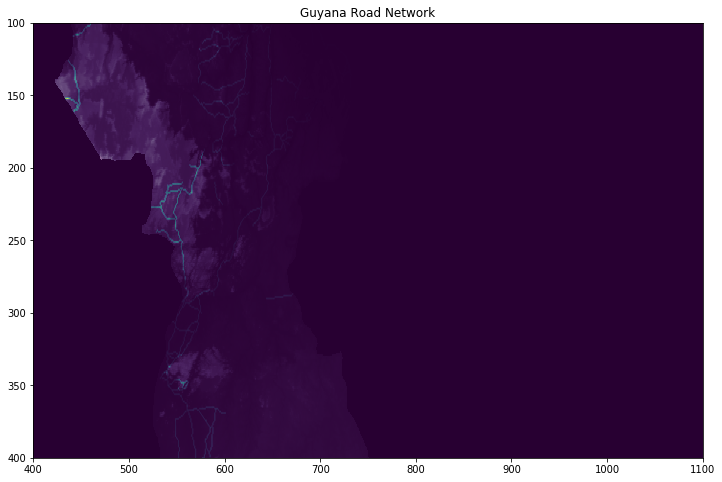

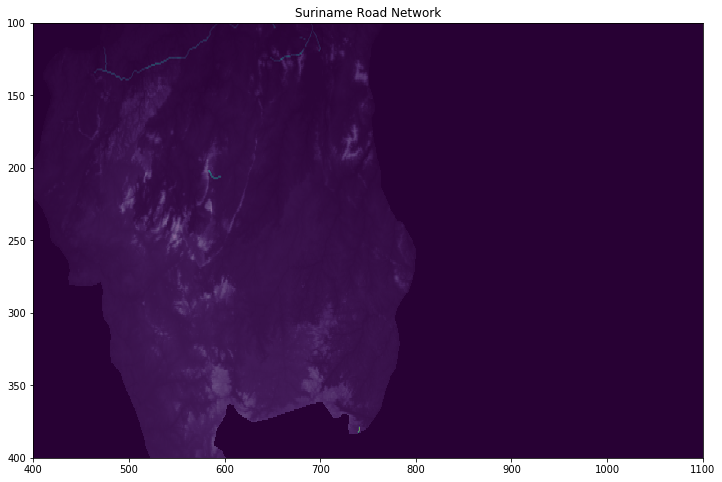

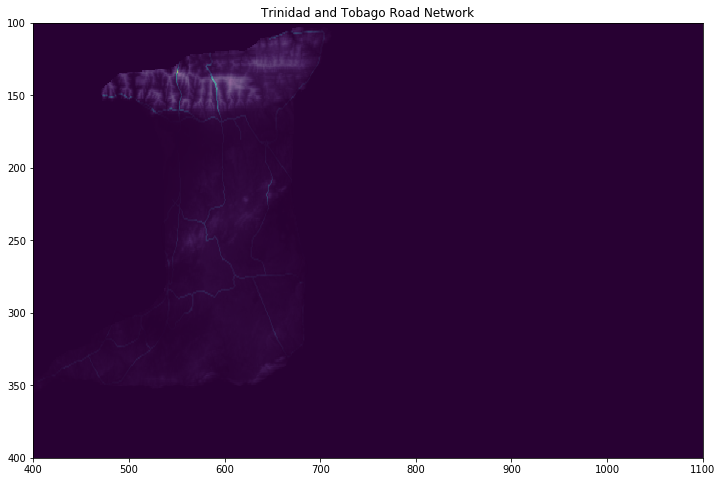

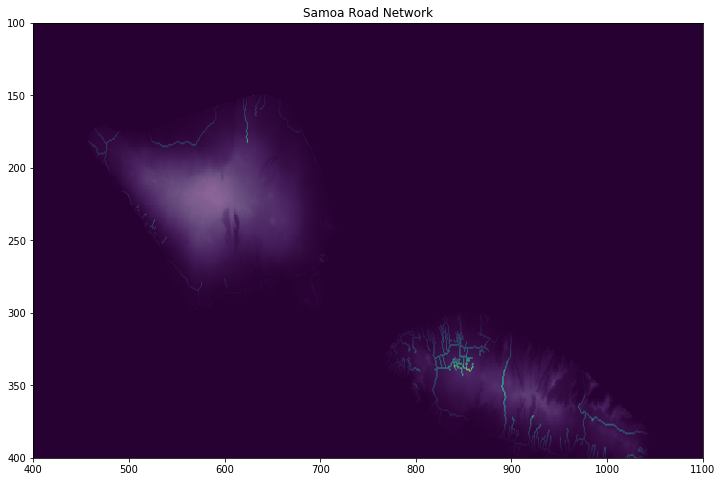

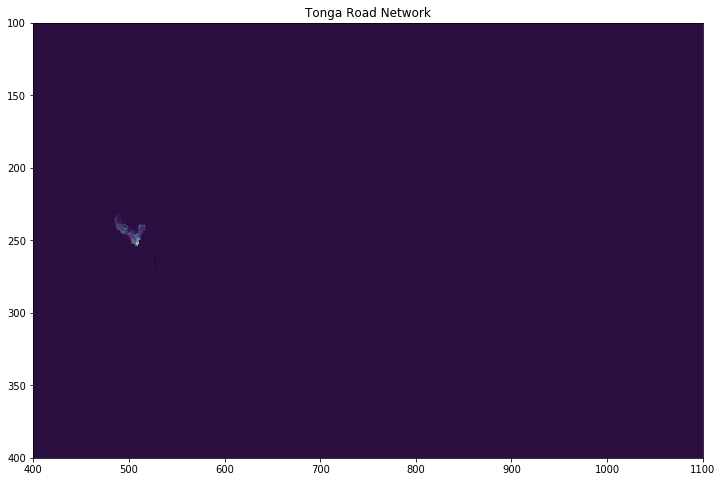

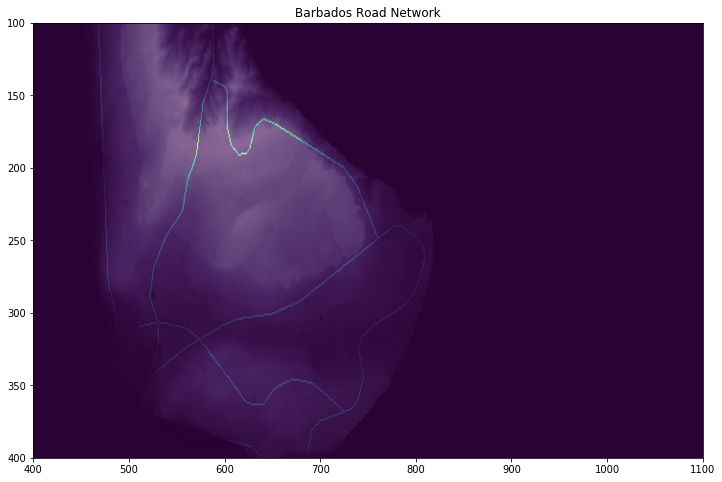

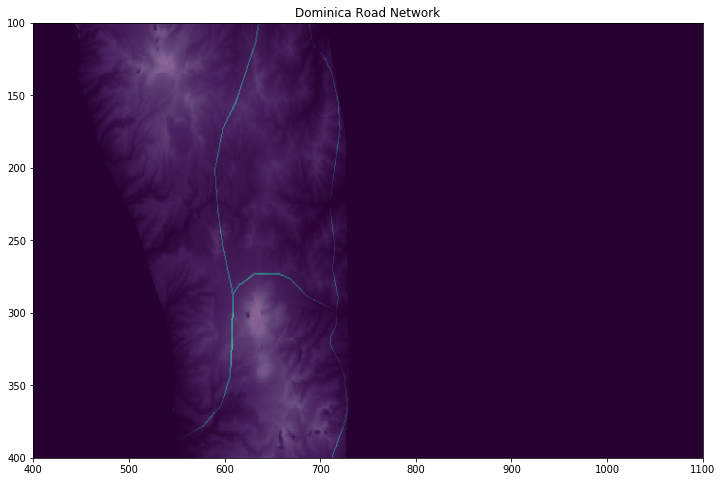

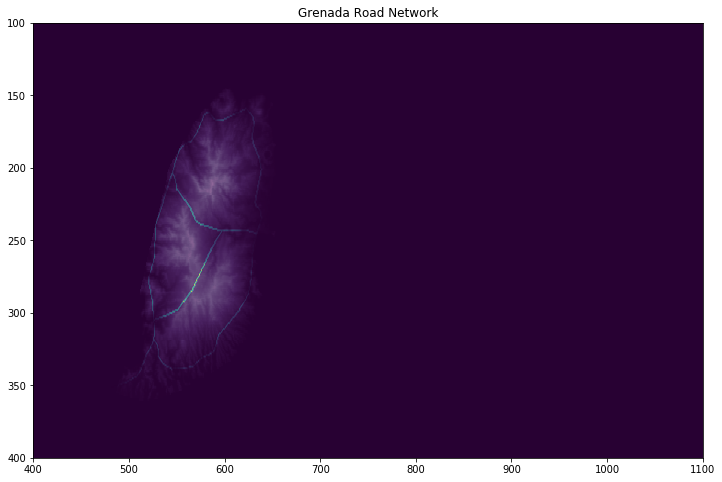

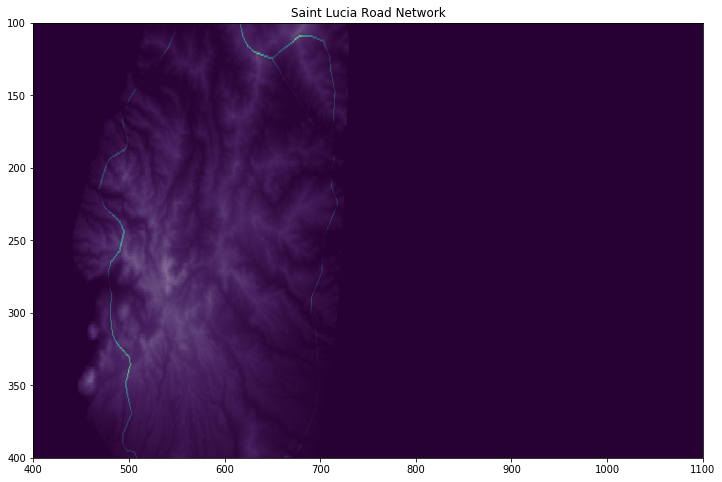

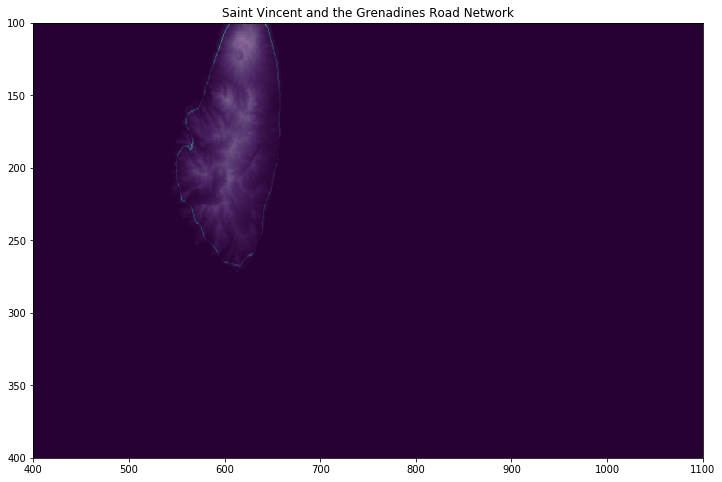

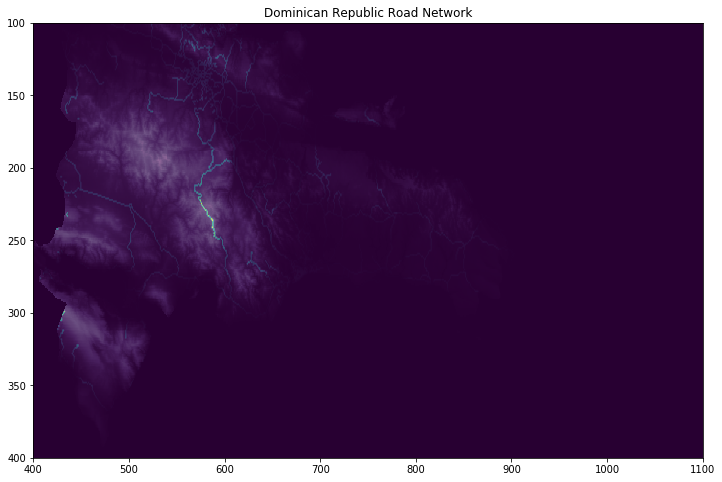

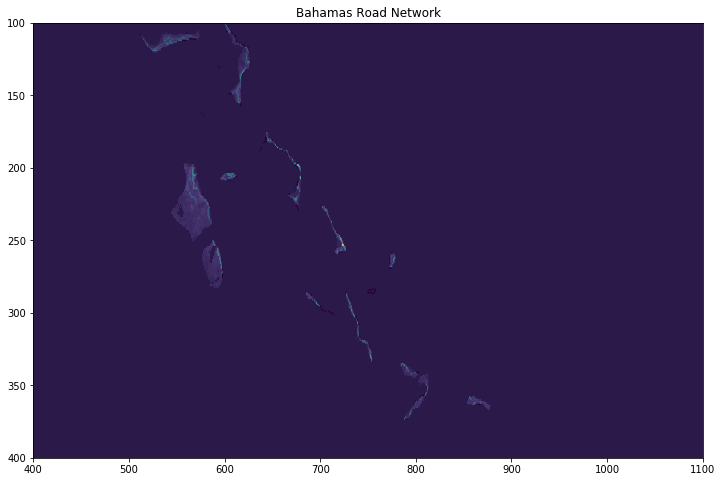

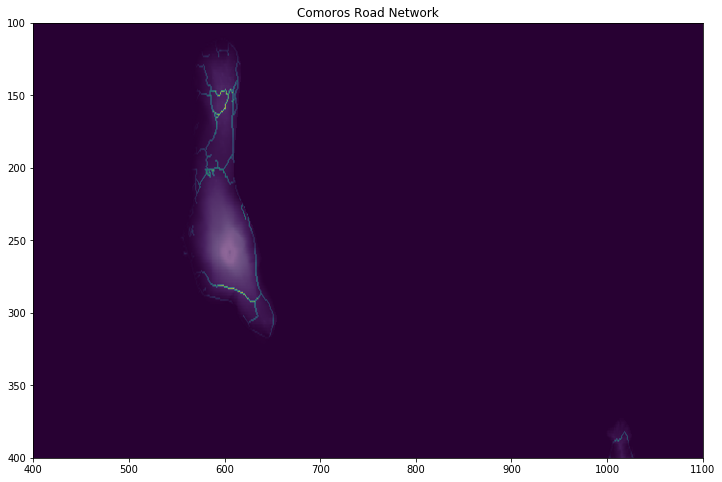

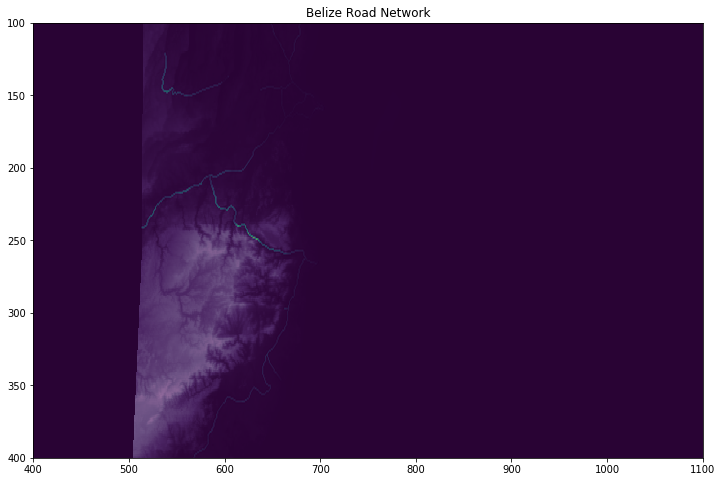

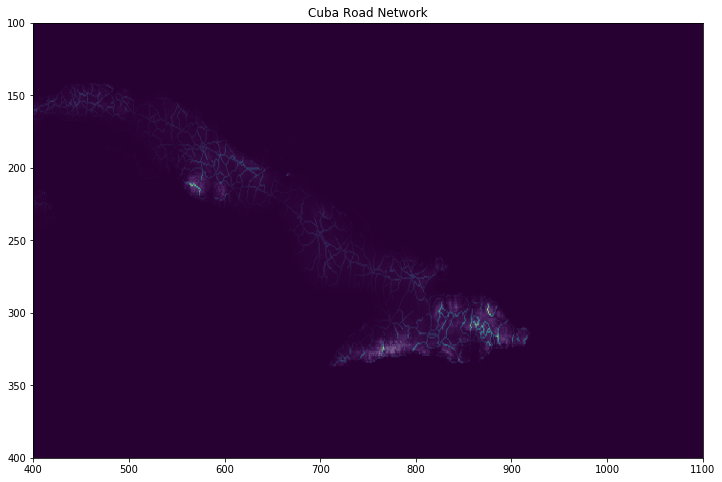

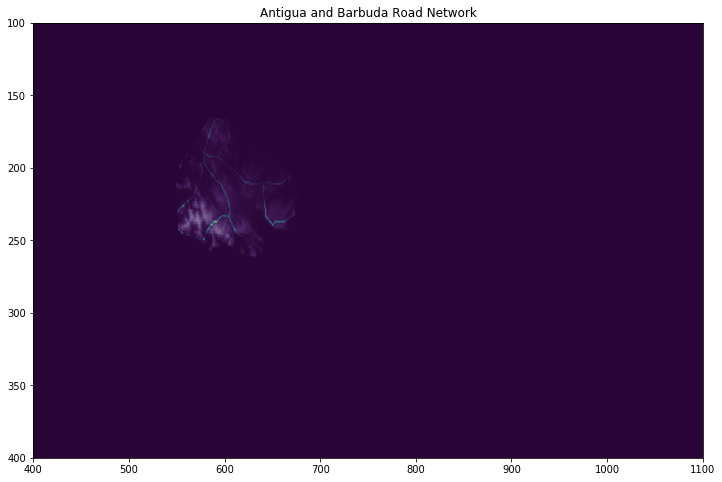

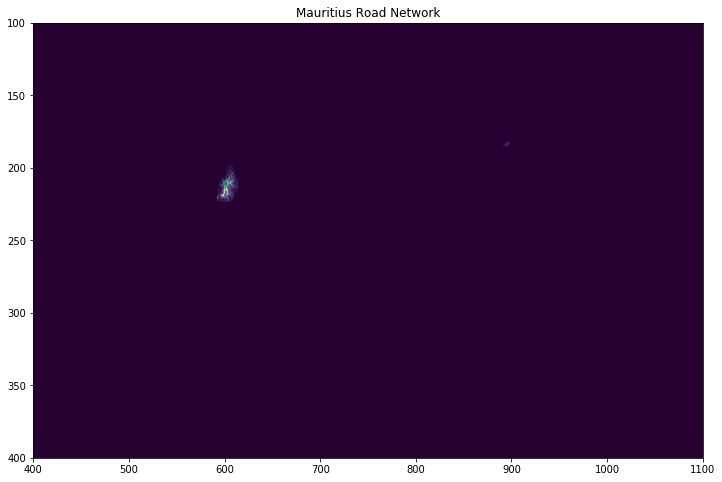

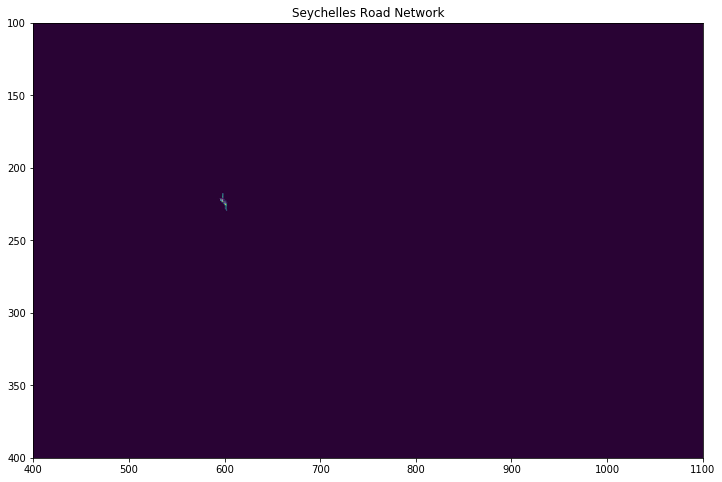

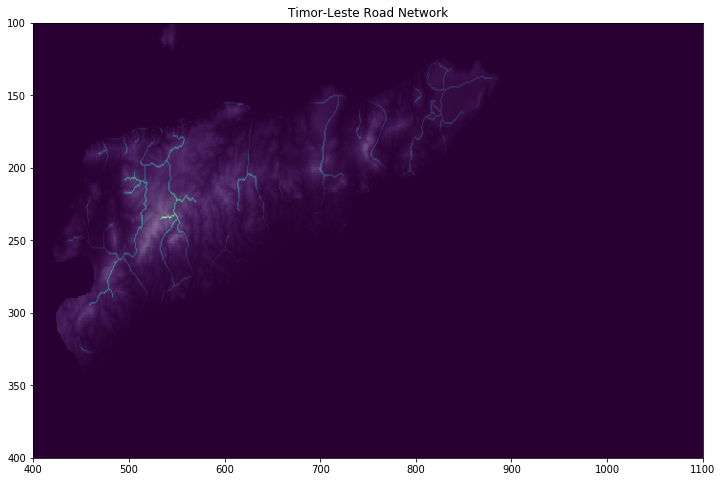

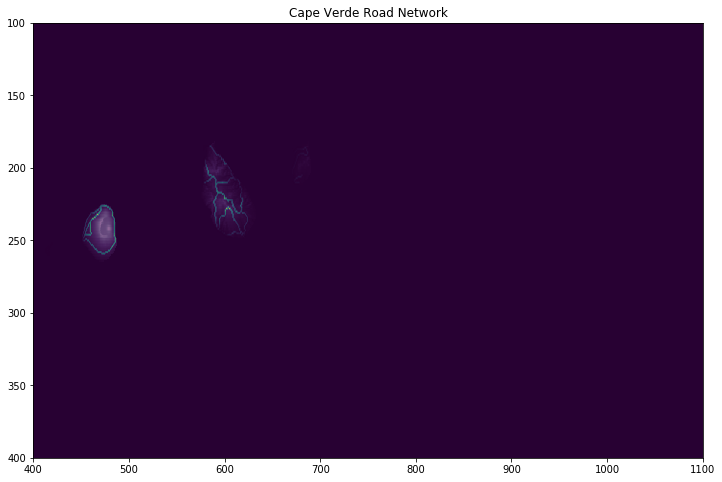

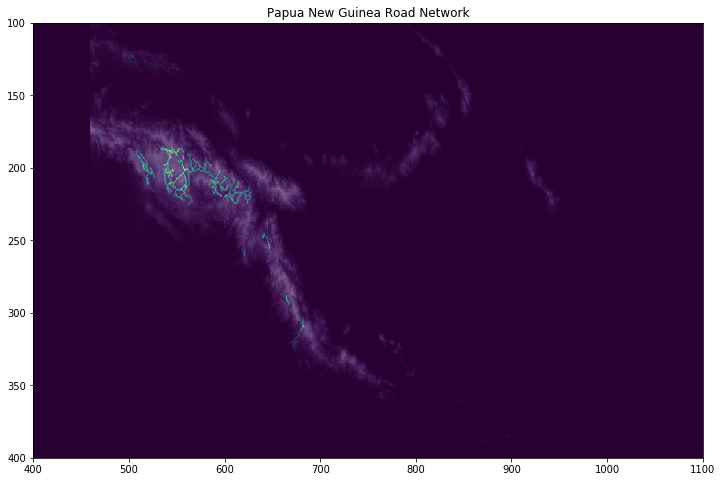

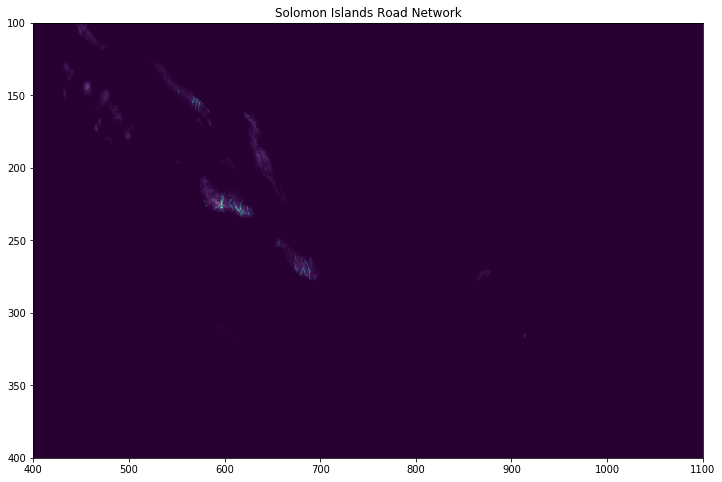

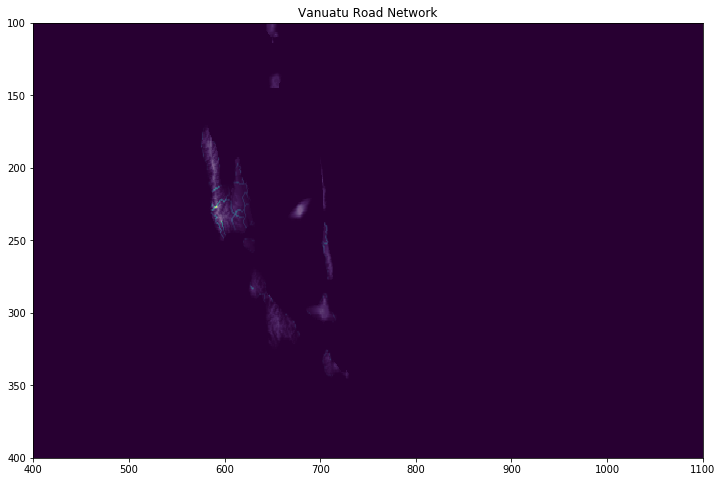

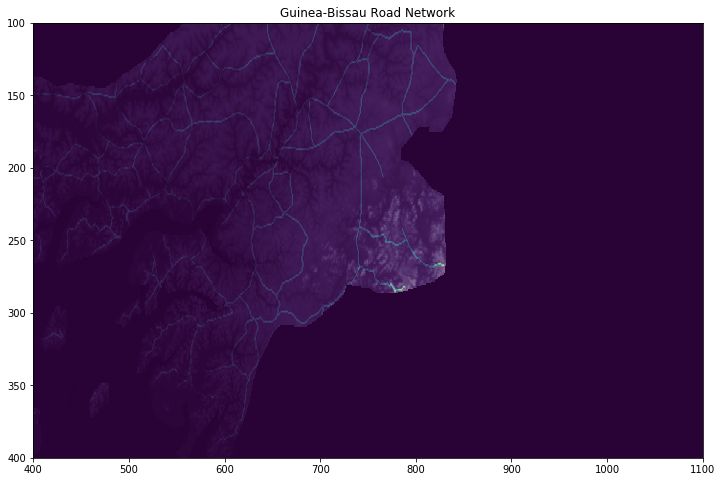

In [44]:
for i in df_roads.index:
    plot_road_dem_rasters(i)

In [324]:
def plot_road__elevation_network(country):
    
    elev_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'Elev_reprojected.tif'
    elev_data = gdal.Open(elev_path)
    elev = elev_data.ReadAsArray()
    elev[elev<0] = -10

    roads_path = '/nfshome/gb1877/gb1877/WorldBank/ESRI/rasters_roads/'+country+'.tif'
    road_data = gdal.Open(roads_path)
    road = road_data.ReadAsArray()
    
    roads_elev = road+elev
    
    roads_elev[road<1.0] = 0
    
    plt.figure(figsize=(12,8))
    
    #iamg2 = plt.imshow(road,aspect='auto', interpolation = 'spline16', cmap='bone', alpha=1.0)
    img1 = plt.imshow(roads_elev,aspect='auto', interpolation = 'nearest', cmap='viridis', alpha=1.0)

    plt.axis([400,1100,400,100])
    
    plt.title("{} Road Network with Elevation".format(country));
    
    plt.show()

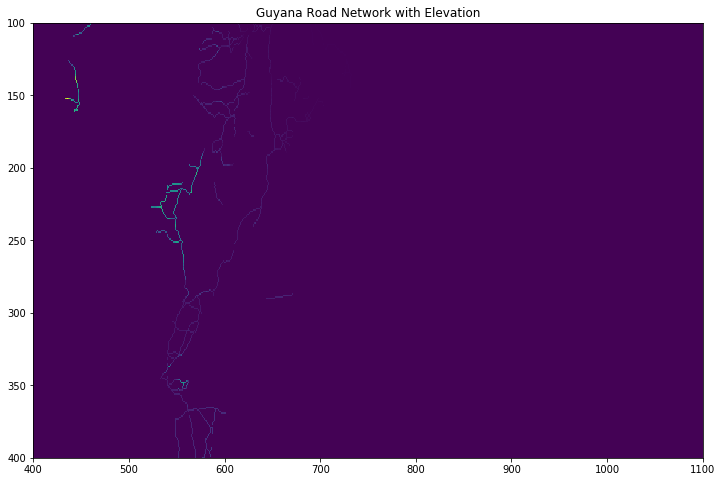

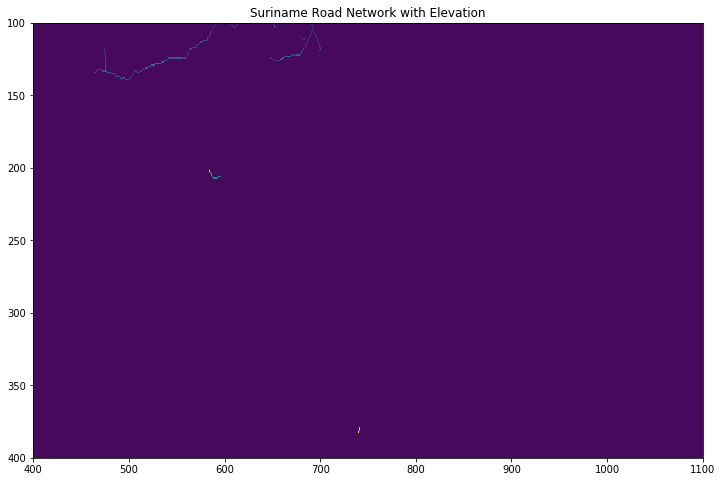

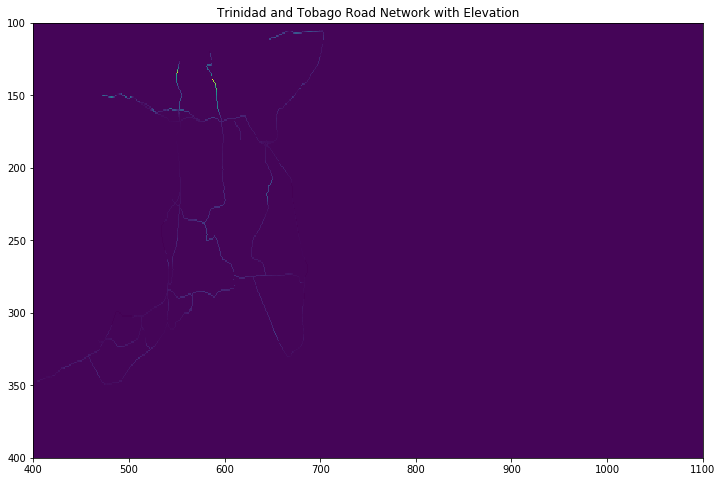

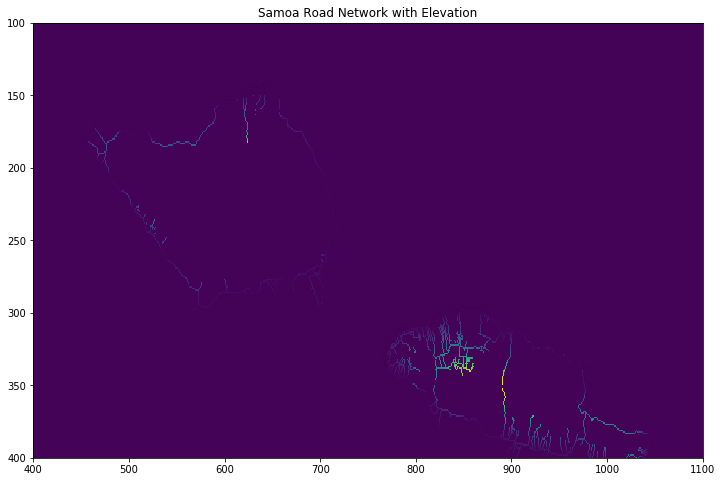

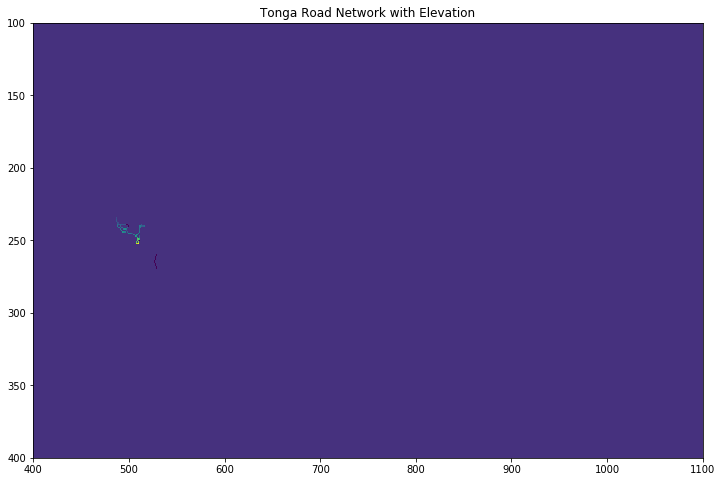

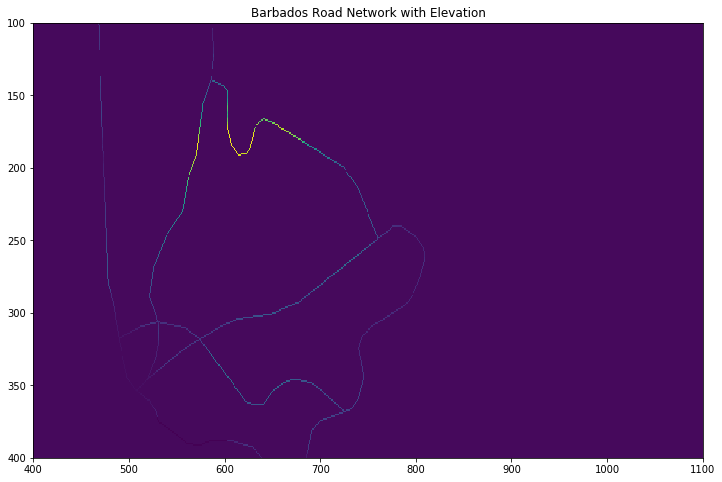

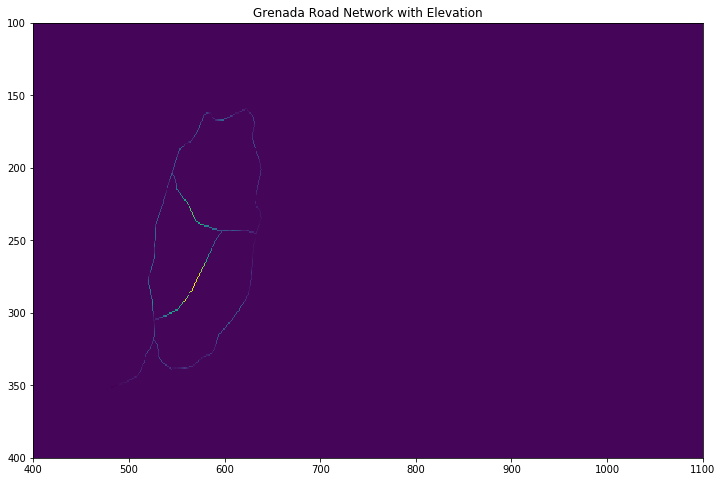

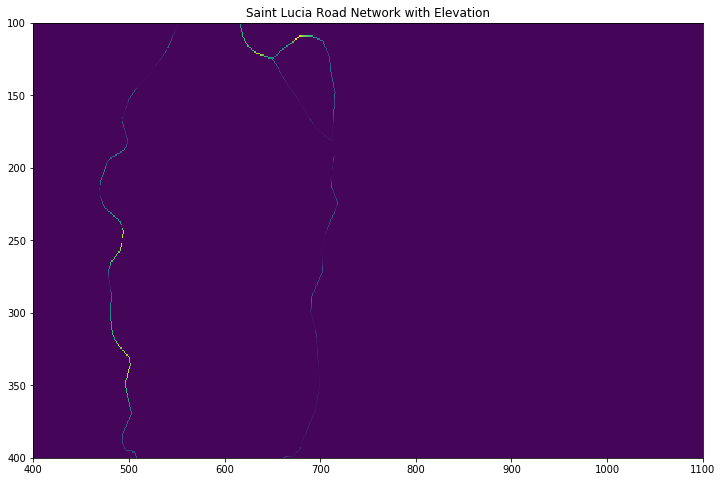

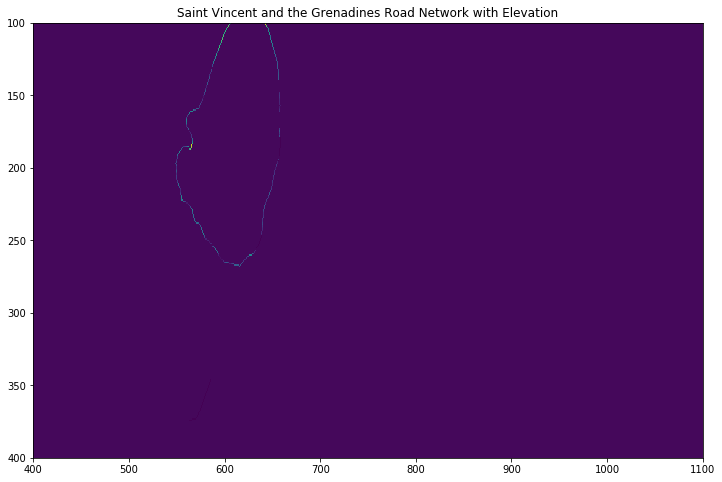

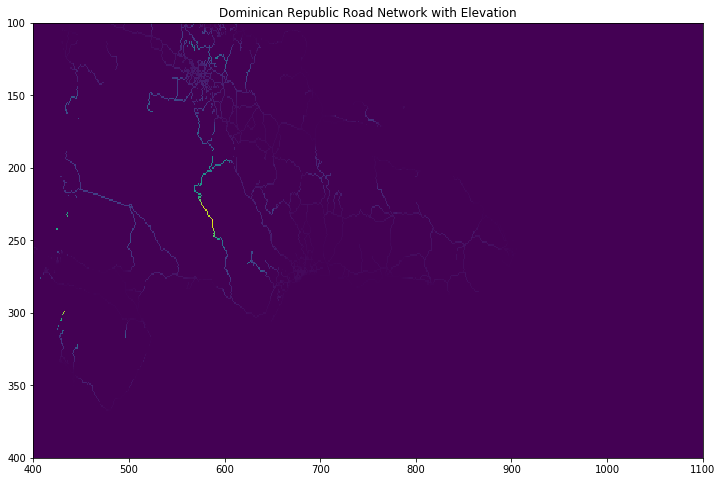

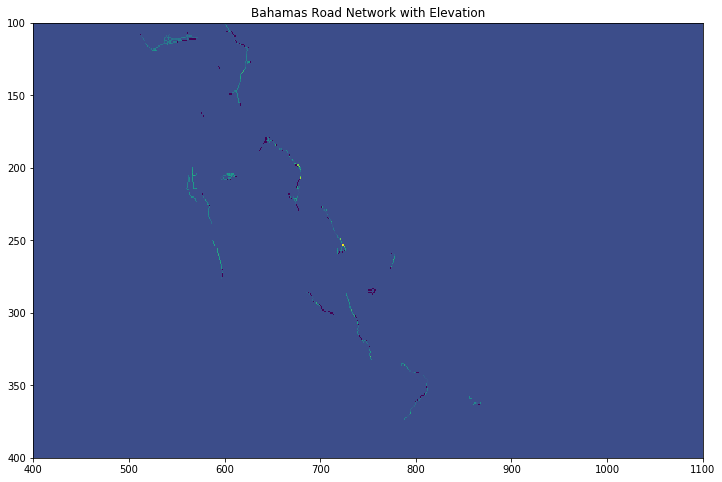

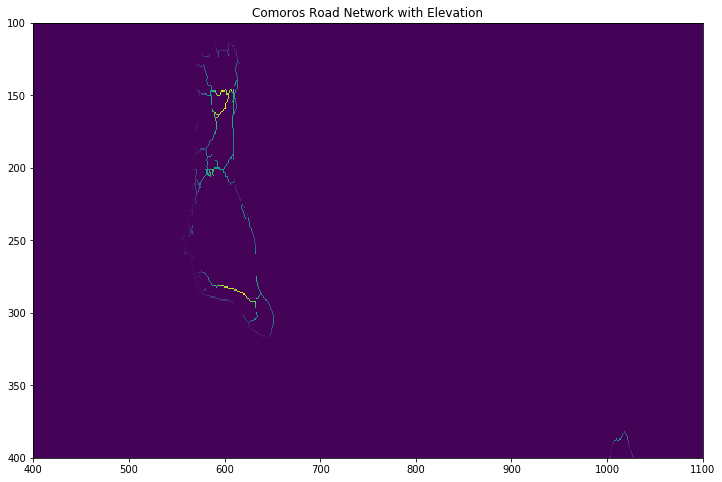

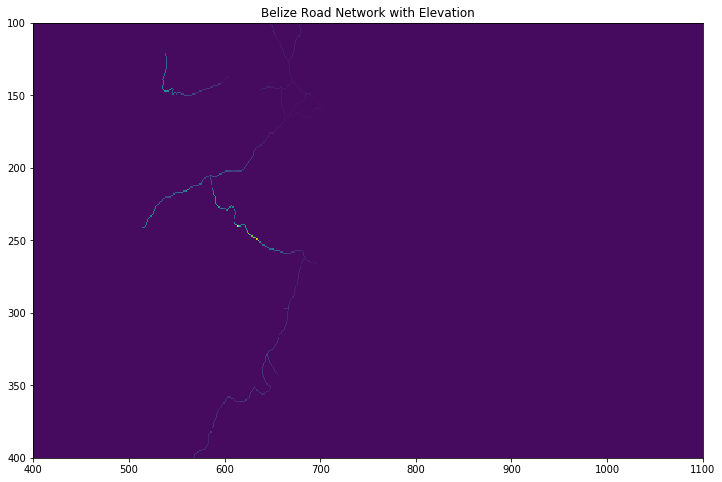

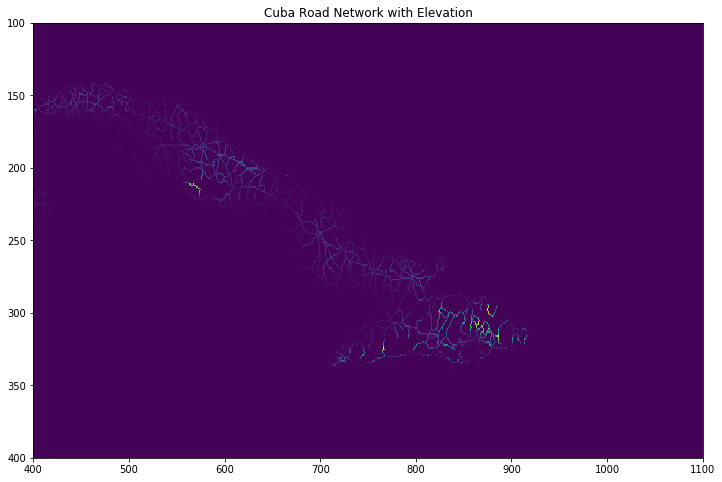

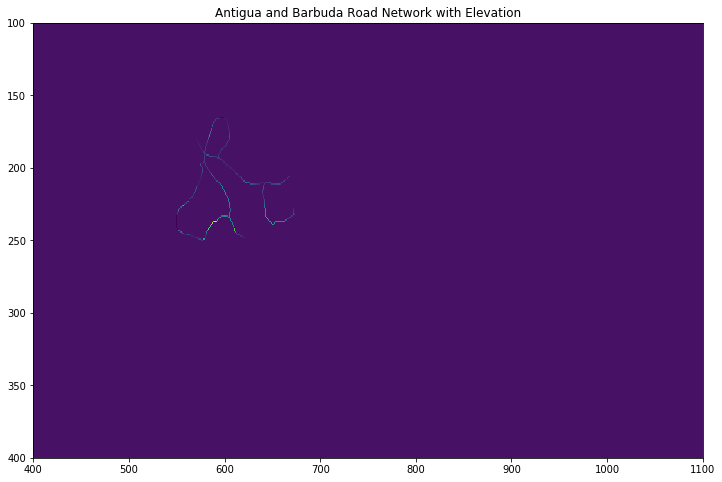

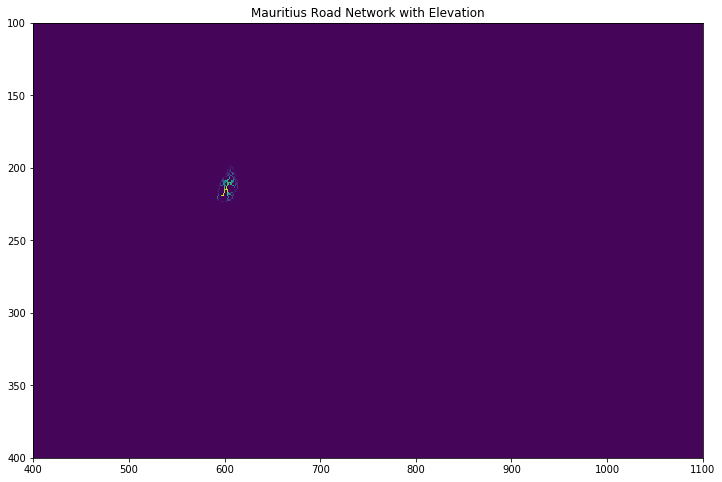

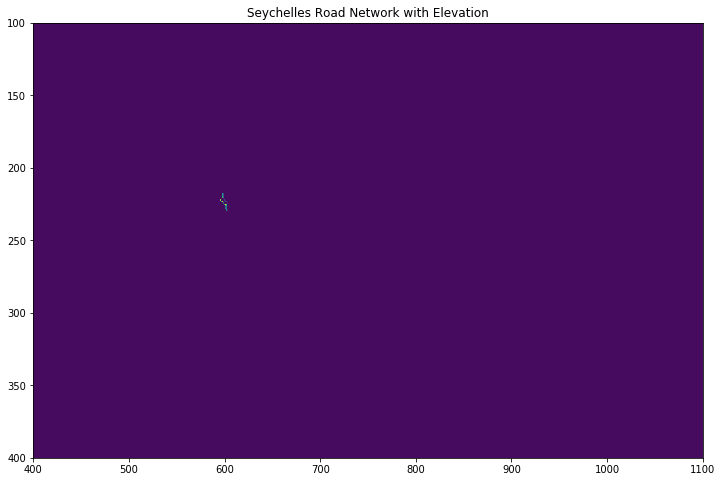

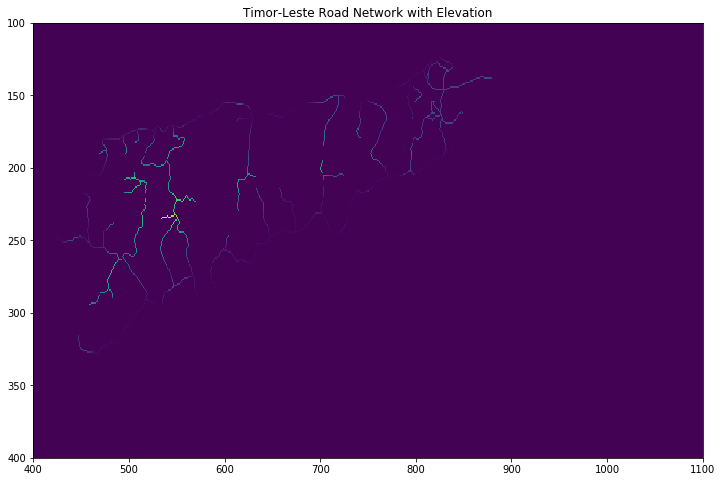

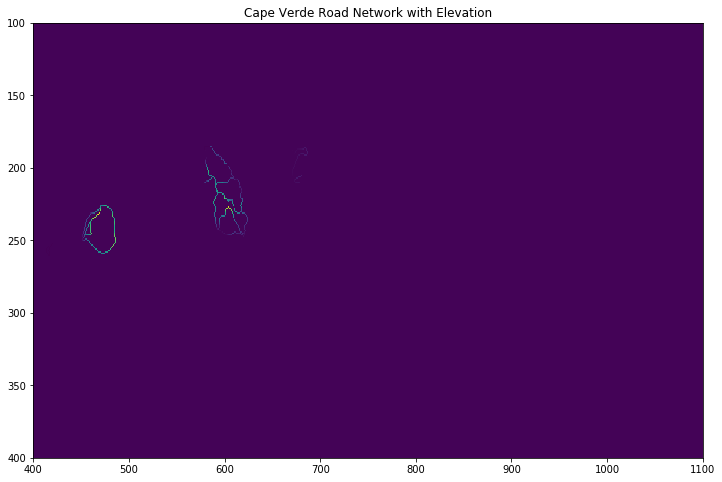

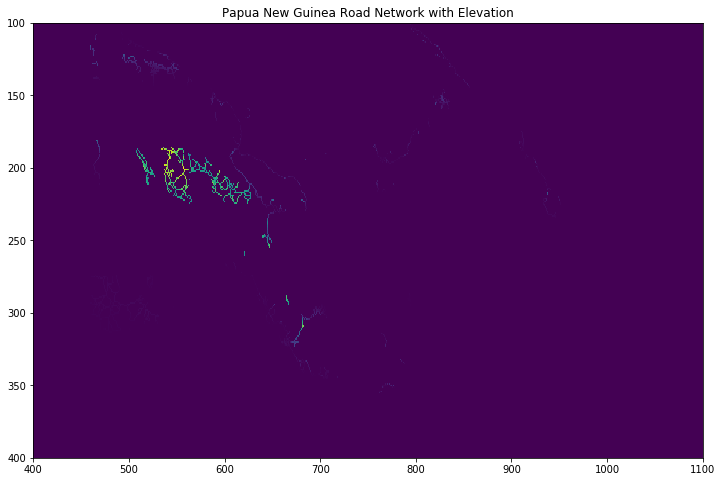

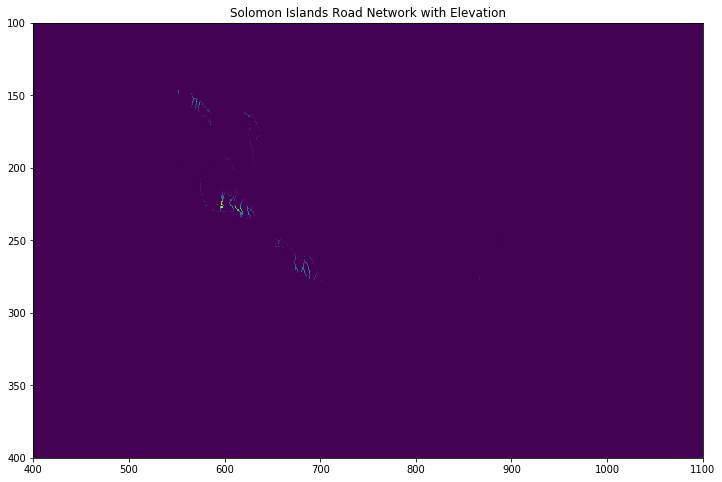

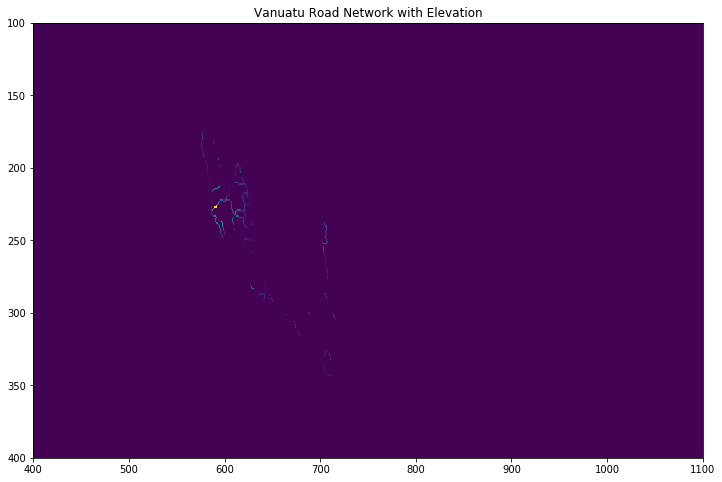

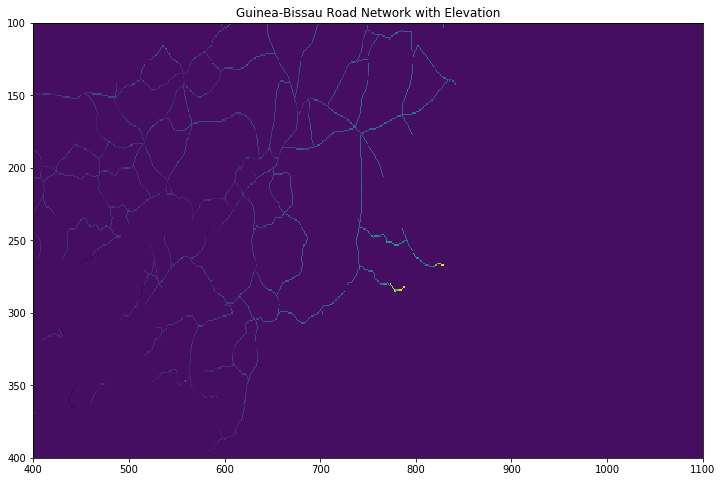

In [325]:
for i in df_roads.index:
    plot_road__elevation_network(i)

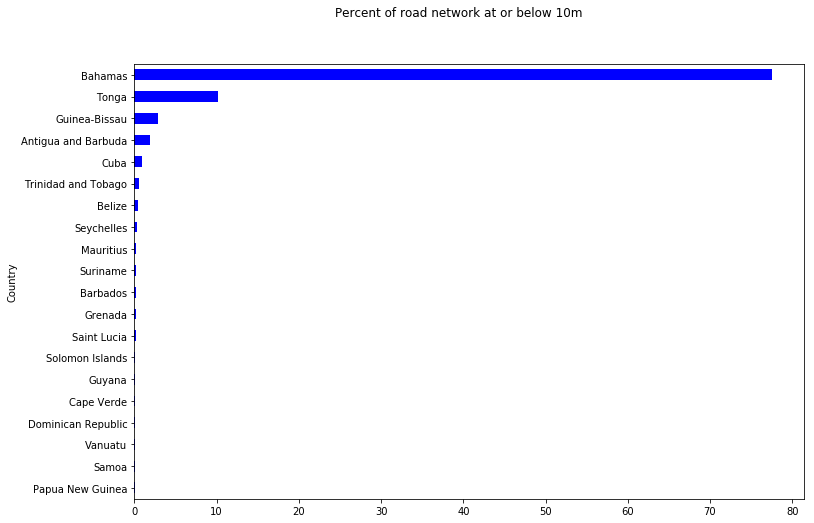

In [138]:
f,ax = plt.subplots(figsize=[12,8])
df_roads['10m'].sort_values(ascending=False)[:20].plot(kind='barh',figsize=[12,8],color='blue',ax=ax)
plt.suptitle("Percent of road network at or below 10m")
ax.invert_yaxis()